# 🏴‍☠️ UAB THE HACK! 2025 - WiFi Dataset Analysis
## AP Time Slot Busyness Analysis

**Objetivo:** Analizar los datos de Access Points (APs) para determinar qué tan ocupado está cada intervalo de tiempo

**Dataset:**
- Access Points (APs): Archivos JSON con snapshots de APs del campus
- Cada snapshot contiene: número de clientes conectados, timestamp, y métricas de rendimiento
- Período: Abril-Julio 2025

**⚠️ Importante - Identificación de APs:**
- Cada AP está **únicamente identificado por su `ip_address`** (IP hasheada para privacidad)
- El campo `name` es solo descriptivo y puede no ser único
- Todos los conteos de APs únicos usan `ip_address` como identificador

**Métricas de "Busyness" (Ocupación):**
- Total de clientes conectados por intervalo de tiempo
- Promedio de clientes por AP por intervalo
- Número de APs activos por intervalo (usando IP hasheada)
- Utilización de CPU promedio por intervalo
- Identificación de horas pico

---


## 📦 1. Importar Librerías

Importamos las librerías necesarias para el análisis de intervalos de tiempo.


In [2]:
# Librerías estándar y científicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from datetime import datetime, timedelta

# Configuración general
warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams.update({
    "figure.figsize": (14, 7),
    "axes.titlesize": 16,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
})

# Carga de funciones personalizadas
import sys
UTILS_PATH = Path('utils').resolve()
if str(UTILS_PATH) not in sys.path:
    sys.path.append(str(UTILS_PATH))
from data_loader import load_aps, print_dataset_summary

print("✅ Librerías y utilidades cargadas correctamente")


✅ Librerías y utilidades cargadas correctamente


## 📂 2. Cargar Datos de Access Points

Cargamos los datos de APs. Puedes ajustar `max_files` para cargar más o menos datos.

**Nota:** Para análisis completo, usa `max_files=None` (puede tardar varios minutos)


In [3]:
# Cargar Access Points
# Ajusta max_files según necesites: None = todos los archivos, o un número específico
df_aps = load_aps(
    data_dir="../realData/aps/aps",
    max_files=None,  # Cambia a None para cargar todos los archivos
    verbose=True
)

print("\n" + "="*60)
print(f"🎯 APs cargados: {len(df_aps):,} registros")
print("="*60)

# Verificar que tenemos los campos necesarios
if 'timestamp' in df_aps.columns:
    print(f"\n📅 Rango temporal:")
    print(f"   Inicio: {df_aps['timestamp'].min()}")
    print(f"   Fin:    {df_aps['timestamp'].max()}")
    print(f"   Días:   {(df_aps['timestamp'].max() - df_aps['timestamp'].min()).days}")
else:
    print("⚠️  No se encontró columna 'timestamp'")


📁 Encontrados 2333 archivos en ../realData/aps/aps
📊 Cargando todos archivos...
   Procesados 10/2333 archivos... (11280 registros)
   Procesados 20/2333 archivos... (22560 registros)
   Procesados 30/2333 archivos... (33834 registros)
   Procesados 40/2333 archivos... (45119 registros)
   Procesados 50/2333 archivos... (56409 registros)
   Procesados 60/2333 archivos... (67699 registros)
   Procesados 70/2333 archivos... (79003 registros)
   Procesados 80/2333 archivos... (90319 registros)
   Procesados 90/2333 archivos... (101630 registros)
   Procesados 100/2333 archivos... (112940 registros)
   Procesados 110/2333 archivos... (124250 registros)
   Procesados 120/2333 archivos... (135593 registros)
   Procesados 130/2333 archivos... (147013 registros)
   Procesados 140/2333 archivos... (158433 registros)
   Procesados 150/2333 archivos... (169853 registros)
   Procesados 160/2333 archivos... (181273 registros)
   Procesados 170/2333 archivos... (192693 registros)
   Procesados 180/2

## 🔍 3. Preparar Datos para Análisis de Intervalos

Extraemos información temporal y preparamos los datos para el análisis por intervalos.


In [4]:
# Crear columnas temporales para análisis
df_aps['date'] = df_aps['timestamp'].dt.date
df_aps['hour'] = df_aps['timestamp'].dt.hour
df_aps['day_of_week'] = df_aps['timestamp'].dt.day_name()
df_aps['day_of_week_num'] = df_aps['timestamp'].dt.dayofweek  # 0=Lunes, 6=Domingo

# Crear intervalos de tiempo (time slots)
# Opción 1: Por hora (más simple)
df_aps['time_slot_hour'] = df_aps['timestamp'].dt.floor('H')

# Opción 2: Por 15 minutos (más detallado)
df_aps['time_slot_15min'] = df_aps['timestamp'].dt.floor('15min')

# Opción 3: Por 30 minutos
df_aps['time_slot_30min'] = df_aps['timestamp'].dt.floor('30min')

print("✅ Columnas temporales creadas:")
print(f"   - time_slot_hour: {df_aps['time_slot_hour'].nunique()} intervalos únicos")
print(f"   - time_slot_15min: {df_aps['time_slot_15min'].nunique()} intervalos únicos")
print(f"   - time_slot_30min: {df_aps['time_slot_30min'].nunique()} intervalos únicos")

# Verificar campos disponibles
print("\n📋 Campos disponibles para análisis:")
print(f"   - client_count: {'✓' if 'client_count' in df_aps.columns else '✗'}")
print(f"   - cpu_utilization: {'✓' if 'cpu_utilization' in df_aps.columns else '✗'}")
print(f"   - name: {'✓' if 'name' in df_aps.columns else '✗'}")


✅ Columnas temporales creadas:
   - time_slot_hour: 665 intervalos únicos
   - time_slot_15min: 1085 intervalos únicos
   - time_slot_30min: 874 intervalos únicos

📋 Campos disponibles para análisis:
   - client_count: ✓
   - cpu_utilization: ✓
   - name: ✓


## 📡 3.5 Análisis del Período de Logging de cada AP

Analizamos con qué frecuencia cada AP reporta su estado. Esto nos ayuda a entender:
- La regularidad del logging
- Intervalos típicos entre reportes
- APs con patrones anómalos (muy frecuentes, muy infrecuentes, o irregulares)


In [5]:
# Analizar el período de logging de cada AP
# Para cada AP (identificado por ip_address), calculamos los intervalos entre reportes consecutivos

# Ordenar por AP y timestamp
df_aps_sorted = df_aps.sort_values(['ip_address', 'timestamp']).copy()

# Calcular diferencias de tiempo entre reportes consecutivos para cada AP
df_aps_sorted['time_diff'] = df_aps_sorted.groupby('ip_address')['timestamp'].diff()

# Convertir a minutos para facilitar el análisis
df_aps_sorted['time_diff_minutes'] = df_aps_sorted['time_diff'].dt.total_seconds() / 60

# Filtrar solo los intervalos válidos (eliminar NaN del primer registro de cada AP)
intervals = df_aps_sorted[df_aps_sorted['time_diff'].notna()].copy()

print("="*80)
print("📡 ANÁLISIS DEL PERÍODO DE LOGGING DE APs")
print("="*80)
print(f"\n📊 Estadísticas generales:")
print(f"   Total de APs únicos: {df_aps['ip_address'].nunique():,}")
print(f"   Total de reportes: {len(df_aps):,}")
print(f"   Intervalos calculados: {len(intervals):,}")
print(f"   APs con múltiples reportes: {intervals['ip_address'].nunique():,}")

# Estadísticas de intervalos
print(f"\n⏱️  Estadísticas de intervalos entre reportes:")
print(f"   Media: {intervals['time_diff_minutes'].mean():.1f} minutos ({intervals['time_diff_minutes'].mean()/60:.2f} horas)")
print(f"   Mediana: {intervals['time_diff_minutes'].median():.1f} minutos ({intervals['time_diff_minutes'].median()/60:.2f} horas)")
print(f"   Mínimo: {intervals['time_diff_minutes'].min():.1f} minutos")
print(f"   Máximo: {intervals['time_diff_minutes'].max():.1f} minutos ({intervals['time_diff_minutes'].max()/60:.1f} horas)")
print(f"   Desviación estándar: {intervals['time_diff_minutes'].std():.1f} minutos")


📡 ANÁLISIS DEL PERÍODO DE LOGGING DE APs

📊 Estadísticas generales:
   Total de APs únicos: 1,166
   Total de reportes: 2,663,195
   Intervalos calculados: 2,662,029
   APs con múltiples reportes: 1,165

⏱️  Estadísticas de intervalos entre reportes:
   Media: 32.1 minutos (0.53 horas)
   Mediana: 0.0 minutos (0.00 horas)
   Mínimo: 0.0 minutos
   Máximo: 177090.1 minutos (2951.5 horas)
   Desviación estándar: 1467.1 minutos


In [6]:
# Calcular estadísticas por AP
ap_logging_stats = intervals.groupby('ip_address').agg({
    'time_diff_minutes': ['mean', 'median', 'std', 'min', 'max', 'count'],
    'name': 'first',  # Para mostrar el nombre del AP
    'timestamp': ['min', 'max']  # Primer y último reporte
}).round(2)

# Aplanar nombres de columnas
ap_logging_stats.columns = ['avg_interval_min', 'median_interval_min', 'std_interval_min', 
                            'min_interval_min', 'max_interval_min', 'num_intervals',
                            'ap_name', 'first_report', 'last_report']

ap_logging_stats = ap_logging_stats.reset_index()

# Calcular duración total de logging para cada AP
ap_logging_stats['total_duration_hours'] = (
    (ap_logging_stats['last_report'] - ap_logging_stats['first_report']).dt.total_seconds() / 3600
)

# Calcular frecuencia esperada vs observada
ap_logging_stats['expected_reports'] = ap_logging_stats['total_duration_hours'] * 60 / ap_logging_stats['avg_interval_min']
ap_logging_stats['actual_reports'] = ap_logging_stats['num_intervals'] + 1  # +1 porque intervals = reports - 1
ap_logging_stats['reporting_consistency'] = ap_logging_stats['actual_reports'] / ap_logging_stats['expected_reports']

print("📊 Estadísticas por AP (Top 10 con más reportes):")
top_reporting_aps = ap_logging_stats.nlargest(10, 'num_intervals')[
    ['ip_address', 'ap_name', 'num_intervals', 'avg_interval_min', 
     'median_interval_min', 'std_interval_min', 'total_duration_hours']
]
print(top_reporting_aps.to_string(index=False))


📊 Estadísticas por AP (Top 10 con más reportes):
     ip_address      ap_name  num_intervals  avg_interval_min  median_interval_min  std_interval_min  total_duration_hours
IP_e3c7433d9738 AP-EDBLANC49           4548             59.46                  0.0           2857.31           4507.266111
IP_0052d5db2f03    AP-LLET13           2332             16.28                  0.0            473.48            632.831667
IP_008fc2c66862    AP-LLET10           2332             55.57                  0.0           2287.28           2159.831667
IP_00ddb37fa7bb    AP-ETSE17           2332             33.64                  0.0           1247.20           1307.355556
IP_00dfd6cf2e05 AP-ENGQUIM07           2332             23.93                  0.0            838.50            929.952222
IP_00fac68c0abe     AP-REC23           2332             17.49                  0.0            574.76            679.855833
IP_010f00eed696     AP-FTI09           2332             55.38                  0.0        

### 3.5.1 Visualización de la Distribución de Intervalos de Logging


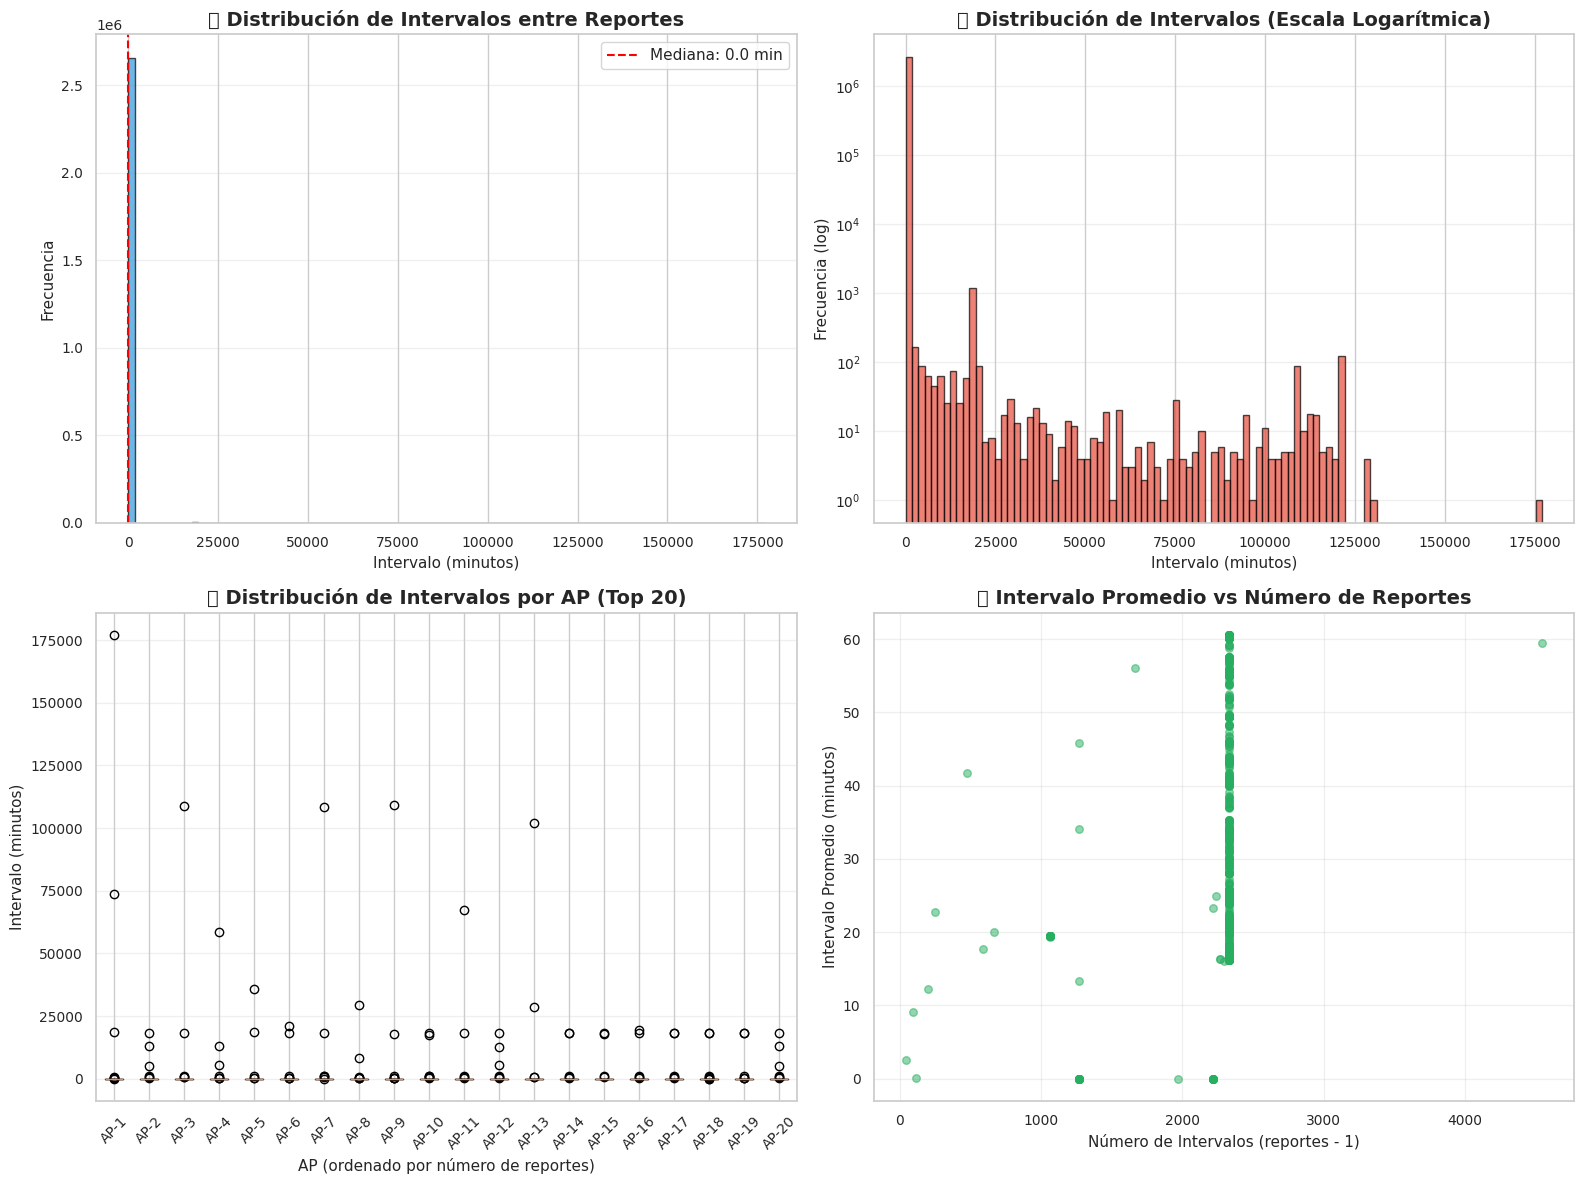


📊 Visualizaciones generadas
   APs con al menos 5 intervalos: 1165


In [7]:
# Visualización 1: Distribución de intervalos entre reportes
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Gráfico 1: Histograma de intervalos (en minutos)
axes[0, 0].hist(intervals['time_diff_minutes'], bins=100, color='#3498db', alpha=0.7, edgecolor='black')
axes[0, 0].set_title('📊 Distribución de Intervalos entre Reportes', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Intervalo (minutos)', fontsize=11)
axes[0, 0].set_ylabel('Frecuencia', fontsize=11)
axes[0, 0].axvline(intervals['time_diff_minutes'].median(), color='red', linestyle='--', 
                   label=f'Mediana: {intervals["time_diff_minutes"].median():.1f} min')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3, axis='y')

# Gráfico 2: Histograma logarítmico (para ver mejor la distribución)
axes[0, 1].hist(intervals['time_diff_minutes'], bins=100, color='#e74c3c', alpha=0.7, edgecolor='black')
axes[0, 1].set_yscale('log')
axes[0, 1].set_title('📊 Distribución de Intervalos (Escala Logarítmica)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Intervalo (minutos)', fontsize=11)
axes[0, 1].set_ylabel('Frecuencia (log)', fontsize=11)
axes[0, 1].grid(alpha=0.3, axis='y')

# Gráfico 3: Box plot de intervalos promedio por AP (top 50 APs)
top_50_aps = ap_logging_stats.nlargest(50, 'num_intervals')
axes[1, 0].boxplot([intervals[intervals['ip_address'] == ip]['time_diff_minutes'].values 
                     for ip in top_50_aps['ip_address'].head(20)], 
                    labels=[f"AP-{i+1}" for i in range(min(20, len(top_50_aps)))],
                    vert=True)
axes[1, 0].set_title('📦 Distribución de Intervalos por AP (Top 20)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('AP (ordenado por número de reportes)', fontsize=11)
axes[1, 0].set_ylabel('Intervalo (minutos)', fontsize=11)
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(alpha=0.3, axis='y')

# Gráfico 4: Intervalo promedio vs número de reportes
scatter_data = ap_logging_stats[ap_logging_stats['num_intervals'] >= 5]  # Solo APs con al menos 5 intervalos
axes[1, 1].scatter(scatter_data['num_intervals'], scatter_data['avg_interval_min'], 
                   alpha=0.5, s=30, color='#27ae60')
axes[1, 1].set_title('📈 Intervalo Promedio vs Número de Reportes', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Número de Intervalos (reportes - 1)', fontsize=11)
axes[1, 1].set_ylabel('Intervalo Promedio (minutos)', fontsize=11)
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Visualizaciones generadas")
print(f"   APs con al menos 5 intervalos: {len(scatter_data)}")


### 3.5.2 Análisis de Patrones de Logging

Identificamos APs con patrones regulares, irregulares, muy frecuentes o muy infrecuentes.


In [8]:
# Clasificar APs según su patrón de logging
# Solo considerar APs con suficientes datos (al menos 5 intervalos)
ap_analysis = ap_logging_stats[ap_logging_stats['num_intervals'] >= 5].copy()

# Definir umbrales
median_interval = intervals['time_diff_minutes'].median()
std_interval = intervals['time_diff_minutes'].std()

# Clasificar por frecuencia
ap_analysis['logging_category'] = 'Regular'
ap_analysis.loc[ap_analysis['avg_interval_min'] < median_interval - std_interval, 'logging_category'] = 'Muy Frecuente'
ap_analysis.loc[ap_analysis['avg_interval_min'] > median_interval + std_interval, 'logging_category'] = 'Poco Frecuente'

# Clasificar por regularidad (baja desviación estándar = regular)
regularity_threshold = ap_analysis['std_interval_min'].quantile(0.33)  # Primer tercil
ap_analysis.loc[ap_analysis['std_interval_min'] > regularity_threshold * 3, 'regularity'] = 'Irregular'
ap_analysis.loc[ap_analysis['std_interval_min'] <= regularity_threshold, 'regularity'] = 'Muy Regular'
ap_analysis.loc[ap_analysis['regularity'].isna(), 'regularity'] = 'Regular'

print("="*80)
print("📊 CLASIFICACIÓN DE APs POR PATRÓN DE LOGGING")
print("="*80)

print(f"\n📈 Por Frecuencia (basado en intervalo promedio):")
freq_counts = ap_analysis['logging_category'].value_counts()
for category, count in freq_counts.items():
    pct = (count / len(ap_analysis)) * 100
    print(f"   {category}: {count} APs ({pct:.1f}%)")

print(f"\n📊 Por Regularidad (basado en desviación estándar de intervalos):")
reg_counts = ap_analysis['regularity'].value_counts()
for category, count in reg_counts.items():
    pct = (count / len(ap_analysis)) * 100
    print(f"   {category}: {count} APs ({pct:.1f}%)")

# Mostrar ejemplos de cada categoría
print(f"\n🔍 Ejemplos de APs por categoría:")

print(f"\n   Muy Frecuentes (intervalo promedio < {median_interval - std_interval:.1f} min):")
very_frequent = ap_analysis[ap_analysis['logging_category'] == 'Muy Frecuente'].nsmallest(5, 'avg_interval_min')
for idx, row in very_frequent.iterrows():
    print(f"      {row['ap_name']} (IP: {row['ip_address'][:20]}...): "
          f"{row['avg_interval_min']:.1f} min promedio, {row['num_intervals']} intervalos")

print(f"\n   Poco Frecuentes (intervalo promedio > {median_interval + std_interval:.1f} min):")
infrequent = ap_analysis[ap_analysis['logging_category'] == 'Poco Frecuente'].nlargest(5, 'avg_interval_min')
for idx, row in infrequent.iterrows():
    print(f"      {row['ap_name']} (IP: {row['ip_address'][:20]}...): "
          f"{row['avg_interval_min']:.1f} min promedio ({row['avg_interval_min']/60:.1f} horas), "
          f"{row['num_intervals']} intervalos")

print(f"\n   Irregulares (alta variabilidad en intervalos):")
irregular = ap_analysis[ap_analysis['regularity'] == 'Irregular'].nlargest(5, 'std_interval_min')
for idx, row in irregular.iterrows():
    print(f"      {row['ap_name']} (IP: {row['ip_address'][:20]}...): "
          f"std={row['std_interval_min']:.1f} min, promedio={row['avg_interval_min']:.1f} min")


📊 CLASIFICACIÓN DE APs POR PATRÓN DE LOGGING

📈 Por Frecuencia (basado en intervalo promedio):
   Regular: 1165 APs (100.0%)

📊 Por Regularidad (basado en desviación estándar de intervalos):
   Regular: 406 APs (34.8%)
   Muy Regular: 385 APs (33.0%)
   Irregular: 374 APs (32.1%)

🔍 Ejemplos de APs por categoría:

   Muy Frecuentes (intervalo promedio < -1467.1 min):

   Poco Frecuentes (intervalo promedio > 1467.1 min):

   Irregulares (alta variabilidad en intervalos):
      AP-EDBLANC49 (IP: IP_e3c7433d9738...): std=2857.3 min, promedio=59.5 min
      AP-IGOP01 (IP: IP_d3d43c4214d1...): std=2705.9 min, promedio=56.6 min
      AP-SAB-S205 (IP: IP_667b9696b435...): std=2664.4 min, promedio=55.7 min
      AP-SAB-S117 (IP: IP_b6aa67a649c7...): std=2664.4 min, promedio=55.7 min
      AP-SAB-S003 (IP: IP_cf37085c261f...): std=2664.4 min, promedio=55.7 min


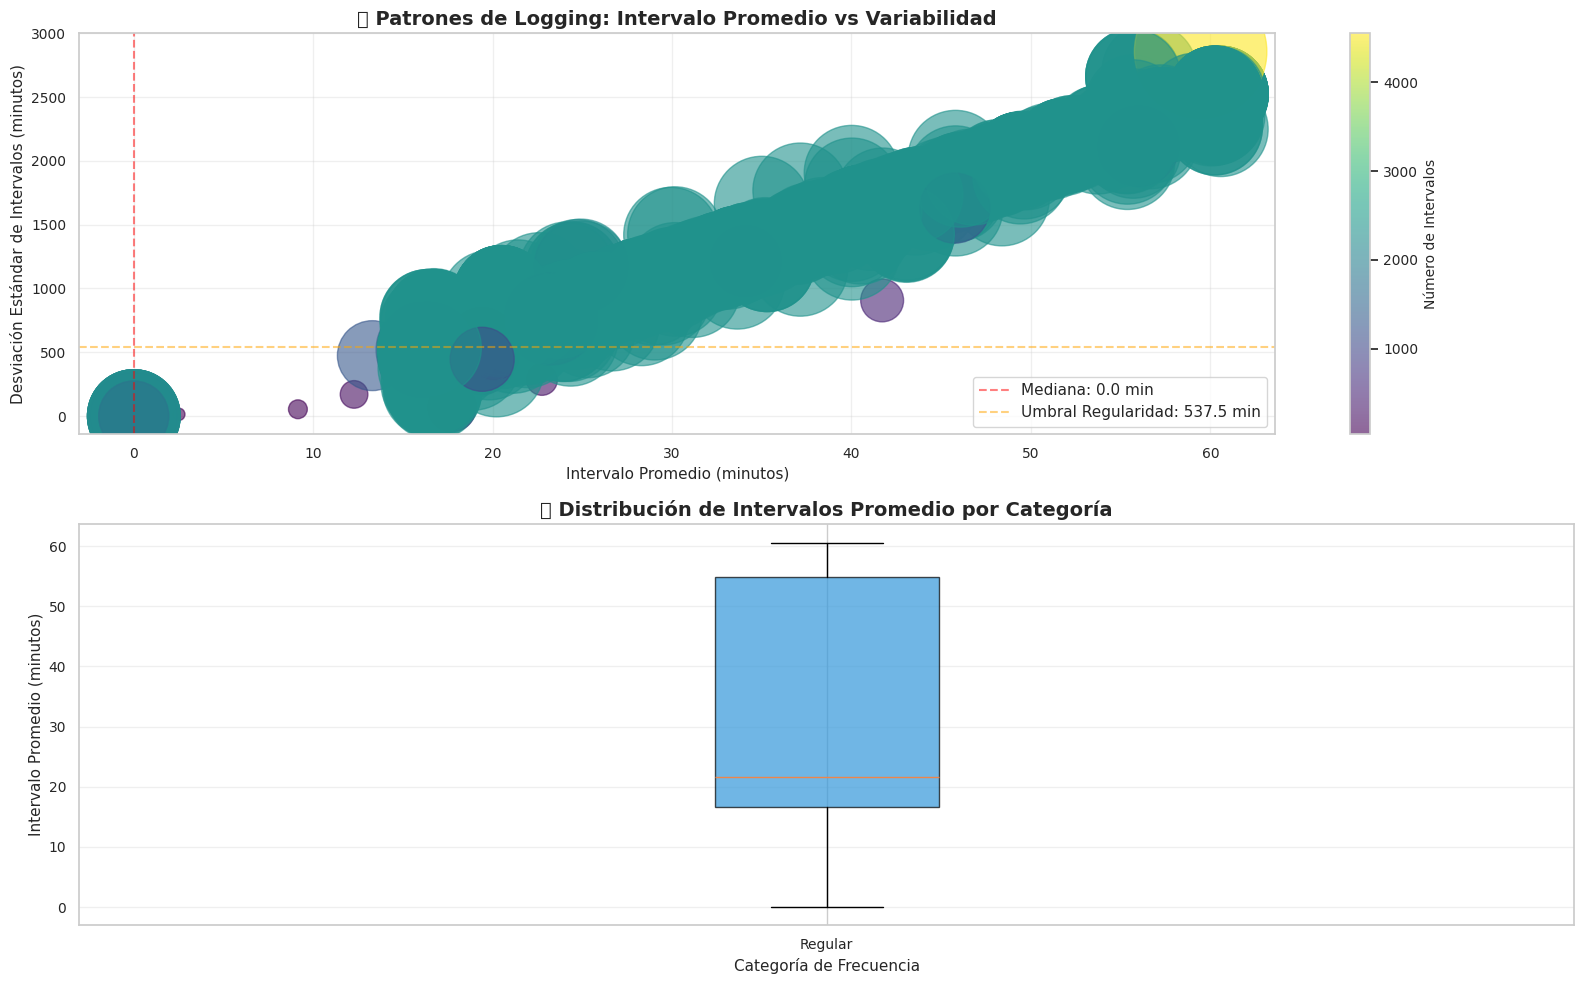

In [9]:
# Visualización de patrones de logging
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Gráfico 1: Intervalo promedio vs desviación estándar (burbujas por número de reportes)
scatter = axes[0].scatter(ap_analysis['avg_interval_min'], ap_analysis['std_interval_min'],
                         s=ap_analysis['num_intervals']*2, alpha=0.6, 
                         c=ap_analysis['num_intervals'], cmap='viridis')
axes[0].set_title('📊 Patrones de Logging: Intervalo Promedio vs Variabilidad', 
                  fontsize=14, fontweight='bold')
axes[0].set_xlabel('Intervalo Promedio (minutos)', fontsize=11)
axes[0].set_ylabel('Desviación Estándar de Intervalos (minutos)', fontsize=11)
axes[0].grid(alpha=0.3)
cbar = plt.colorbar(scatter, ax=axes[0])
cbar.set_label('Número de Intervalos', fontsize=10)

# Añadir líneas de referencia
axes[0].axvline(median_interval, color='red', linestyle='--', alpha=0.5, label=f'Mediana: {median_interval:.1f} min')
axes[0].axhline(regularity_threshold, color='orange', linestyle='--', alpha=0.5, 
                label=f'Umbral Regularidad: {regularity_threshold:.1f} min')
axes[0].legend()

# Gráfico 2: Distribución de intervalos promedio por categoría
categories = ['Muy Frecuente', 'Regular', 'Poco Frecuente']
colors_cat = {'Muy Frecuente': '#e74c3c', 'Regular': '#3498db', 'Poco Frecuente': '#95a5a6'}
data_by_category = [ap_analysis[ap_analysis['logging_category'] == cat]['avg_interval_min'].values 
                   for cat in categories if cat in ap_analysis['logging_category'].values]

bp = axes[1].boxplot(data_by_category, labels=[cat for cat in categories if cat in ap_analysis['logging_category'].values],
                     patch_artist=True)
for patch, cat in zip(bp['boxes'], [cat for cat in categories if cat in ap_analysis['logging_category'].values]):
    patch.set_facecolor(colors_cat.get(cat, '#3498db'))
    patch.set_alpha(0.7)

axes[1].set_title('📦 Distribución de Intervalos Promedio por Categoría', 
                  fontsize=14, fontweight='bold')
axes[1].set_ylabel('Intervalo Promedio (minutos)', fontsize=11)
axes[1].set_xlabel('Categoría de Frecuencia', fontsize=11)
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


### 3.5.3 Análisis Temporal del Logging

Analizamos cómo varía el período de logging a lo largo del tiempo.


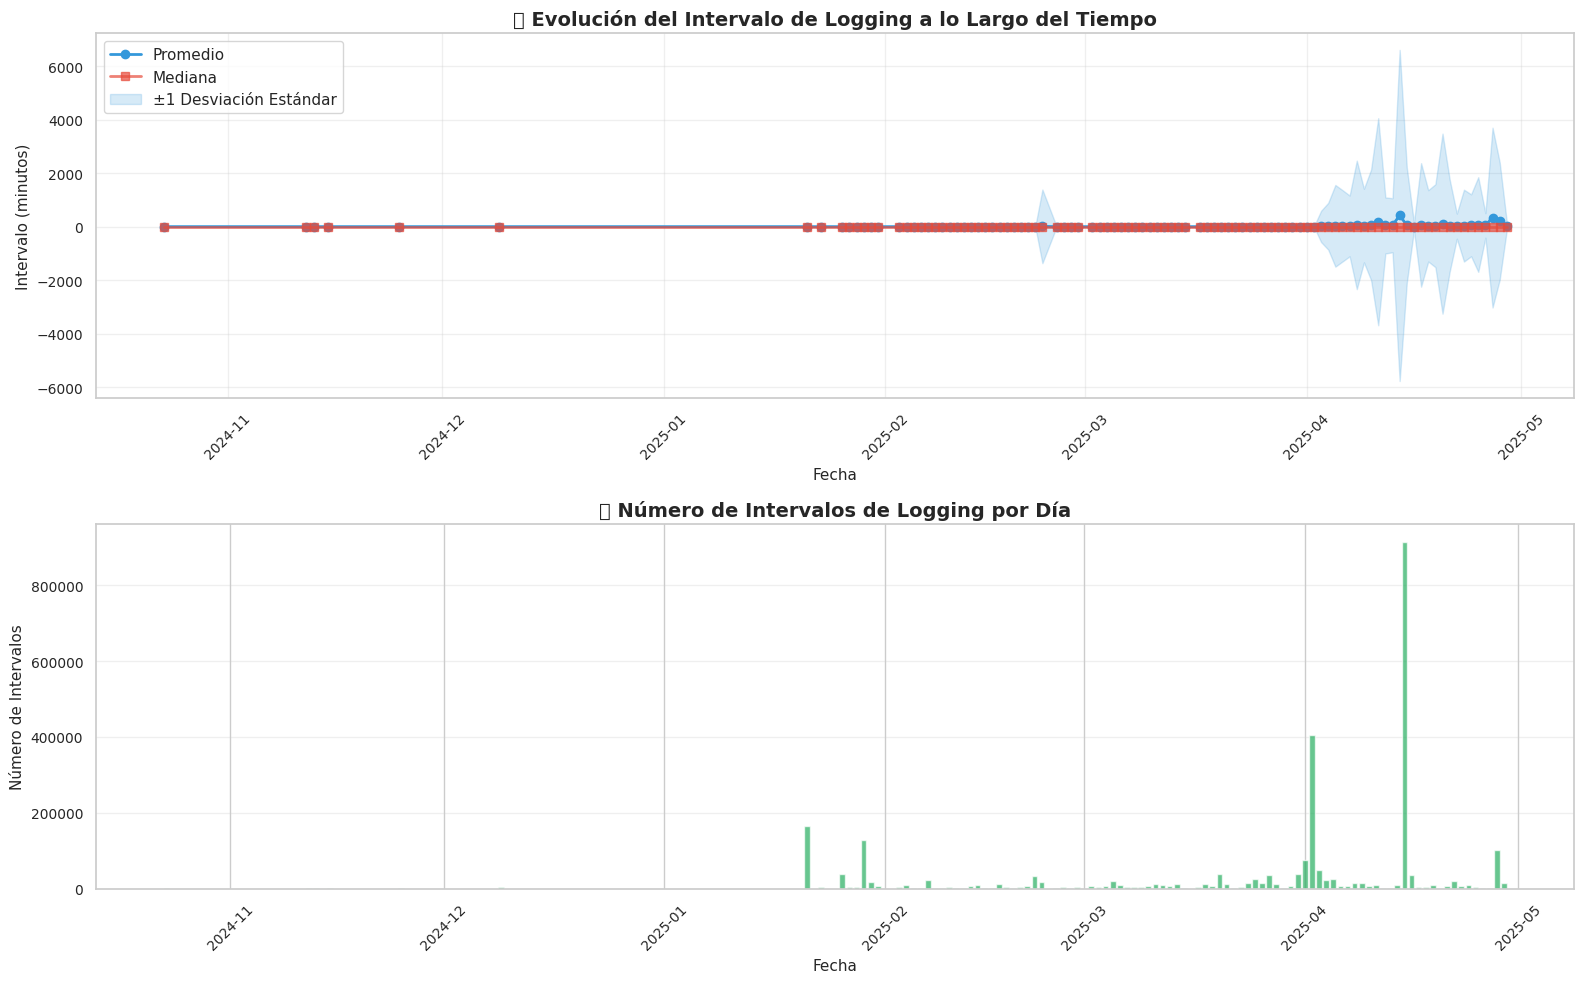


📊 Resumen temporal:
   Días con datos: 97
   Intervalo promedio general: 22.0 minutos
   Día con más actividad: 2025-04-15 (915,153 intervalos)
   Día con menos actividad: 2025-02-16 (1,061 intervalos)


In [10]:
# Analizar cómo varía el intervalo de logging a lo largo del tiempo
# Agrupar intervalos por fecha y calcular estadísticas
intervals['date'] = intervals['timestamp'].dt.date
daily_intervals = intervals.groupby('date').agg({
    'time_diff_minutes': ['mean', 'median', 'std', 'count']
}).round(2)

daily_intervals.columns = ['avg_interval', 'median_interval', 'std_interval', 'num_intervals']
daily_intervals = daily_intervals.reset_index()
daily_intervals['date'] = pd.to_datetime(daily_intervals['date'])

# Visualización temporal
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Gráfico 1: Intervalo promedio por día
axes[0].plot(daily_intervals['date'], daily_intervals['avg_interval'], 
             marker='o', linewidth=2, markersize=6, color='#3498db', label='Promedio')
axes[0].plot(daily_intervals['date'], daily_intervals['median_interval'], 
             marker='s', linewidth=2, markersize=6, color='#e74c3c', label='Mediana', alpha=0.7)
axes[0].fill_between(daily_intervals['date'], 
                     daily_intervals['avg_interval'] - daily_intervals['std_interval'],
                     daily_intervals['avg_interval'] + daily_intervals['std_interval'],
                     alpha=0.2, color='#3498db', label='±1 Desviación Estándar')
axes[0].set_title('📅 Evolución del Intervalo de Logging a lo Largo del Tiempo', 
                  fontsize=14, fontweight='bold')
axes[0].set_xlabel('Fecha', fontsize=11)
axes[0].set_ylabel('Intervalo (minutos)', fontsize=11)
axes[0].legend()
axes[0].grid(alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Gráfico 2: Número de intervalos por día (actividad de logging)
axes[1].bar(daily_intervals['date'], daily_intervals['num_intervals'], 
            color='#27ae60', alpha=0.7, width=0.8)
axes[1].set_title('📊 Número de Intervalos de Logging por Día', 
                  fontsize=14, fontweight='bold')
axes[1].set_xlabel('Fecha', fontsize=11)
axes[1].set_ylabel('Número de Intervalos', fontsize=11)
axes[1].grid(alpha=0.3, axis='y')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print(f"\n📊 Resumen temporal:")
print(f"   Días con datos: {len(daily_intervals)}")
print(f"   Intervalo promedio general: {daily_intervals['avg_interval'].mean():.1f} minutos")
print(f"   Día con más actividad: {daily_intervals.loc[daily_intervals['num_intervals'].idxmax(), 'date'].date()} "
      f"({daily_intervals['num_intervals'].max():,} intervalos)")
print(f"   Día con menos actividad: {daily_intervals.loc[daily_intervals['num_intervals'].idxmin(), 'date'].date()} "
      f"({daily_intervals['num_intervals'].min():,} intervalos)")


## 📊 4. Análisis de Ocupación por Intervalos de Tiempo

Analizamos qué tan ocupado está cada intervalo de tiempo usando diferentes métricas.


In [11]:
# Análisis por hora (time_slot_hour)
# Agrupar por intervalo de hora y calcular métricas de ocupación
# Nota: ip_address es el identificador único de cada AP (IP hasheada para privacidad)
hourly_stats = df_aps.groupby('time_slot_hour').agg({
    'client_count': ['sum', 'mean', 'max', 'std'],
    'ip_address': 'nunique',  # Número de APs únicos en ese intervalo (usando IP hasheada)
    'cpu_utilization': 'mean' if 'cpu_utilization' in df_aps.columns else lambda x: 0
}).round(2)

# Aplanar nombres de columnas
hourly_stats.columns = ['total_clients', 'avg_clients_per_ap', 'max_clients_single_ap', 
                        'std_clients', 'unique_aps', 'avg_cpu_utilization']

# Resetear índice para tener time_slot_hour como columna
hourly_stats = hourly_stats.reset_index()

# Agregar información adicional
hourly_stats['hour'] = hourly_stats['time_slot_hour'].dt.hour
hourly_stats['date'] = hourly_stats['time_slot_hour'].dt.date
hourly_stats['day_of_week'] = hourly_stats['time_slot_hour'].dt.day_name()

print("📊 Estadísticas de ocupación por hora:")
print(hourly_stats.head(10))


📊 Estadísticas de ocupación por hora:
       time_slot_hour  total_clients  avg_clients_per_ap  \
0 2024-10-23 16:00:00              0                0.00   
1 2024-11-12 10:00:00              0                0.00   
2 2024-11-13 16:00:00              0                0.00   
3 2024-11-15 09:00:00              0                0.00   
4 2024-11-25 09:00:00              0                0.00   
5 2024-12-09 13:00:00              0                0.00   
6 2024-12-09 15:00:00              0                0.00   
7 2025-01-21 09:00:00         648191                4.00   
8 2025-01-21 10:00:00            678                0.53   
9 2025-01-21 17:00:00            913                1.32   

   max_clients_single_ap  std_clients  unique_aps  avg_cpu_utilization  hour  \
0                      0         0.00           1                 4.00    16   
1                      0         0.00           1                 9.00    10   
2                      0         0.00           1            

### 4.1 Visualización: Total de Clientes por Hora del Día

Muestra el total de clientes conectados en cada hora del día (promedio entre todos los días).


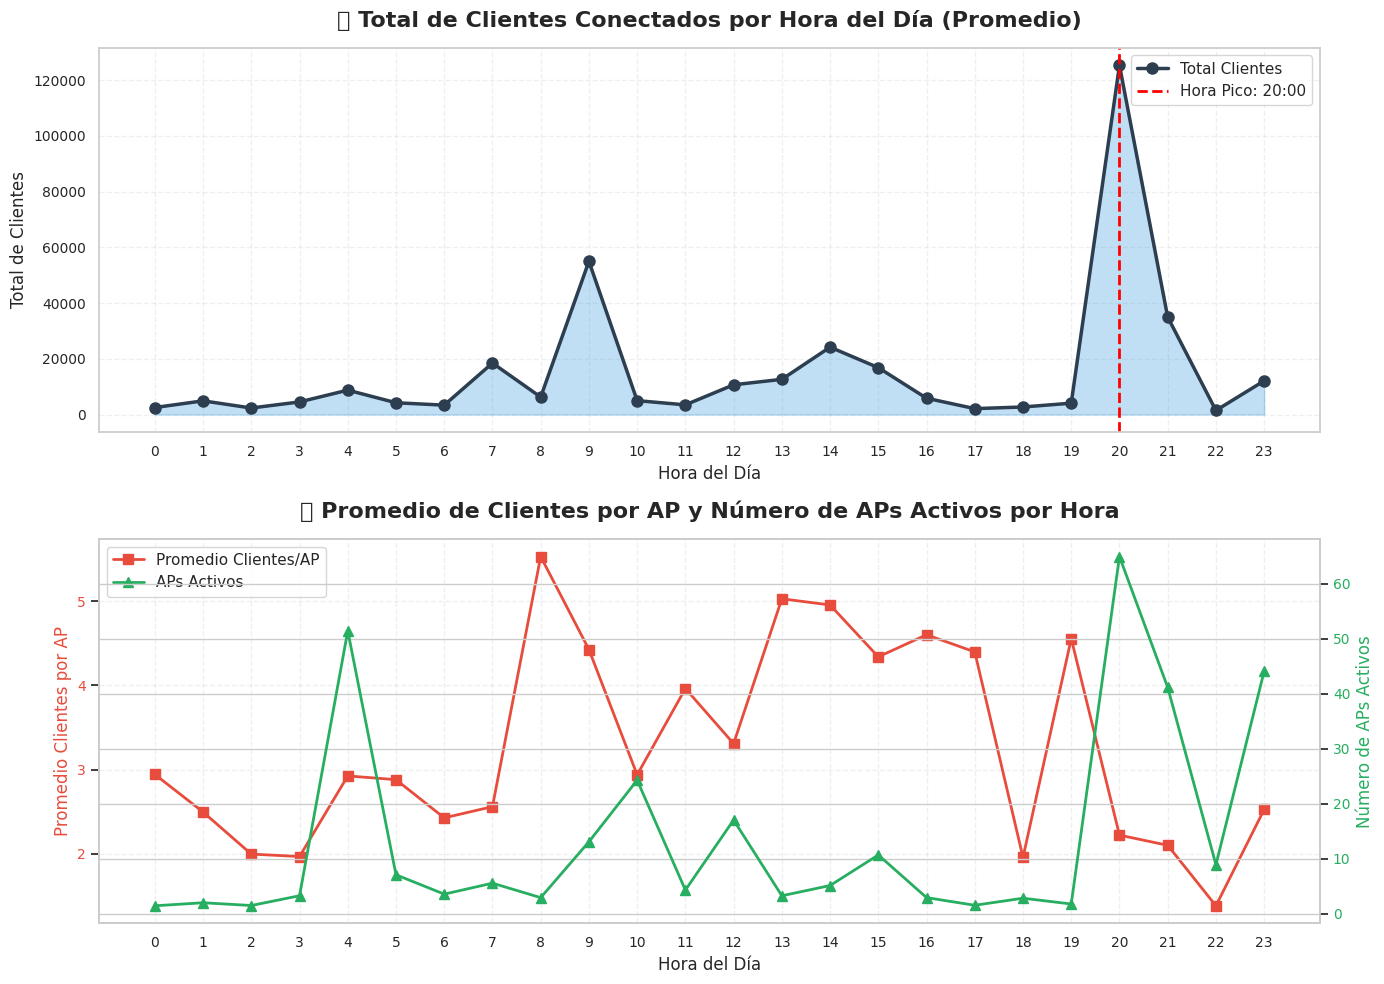


🕐 Hora pico: 20:00 con 125,365 clientes conectados en promedio
📊 Promedio de clientes por AP en hora pico: 2.2


In [12]:
# Agrupar por hora del día (promedio entre todos los días)
hourly_avg = hourly_stats.groupby('hour').agg({
    'total_clients': 'mean',
    'avg_clients_per_ap': 'mean',
    'unique_aps': 'mean',
    'avg_cpu_utilization': 'mean'
}).reset_index()

# Crear visualización
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Gráfico 1: Total de clientes por hora
axes[0].plot(hourly_avg['hour'], hourly_avg['total_clients'], 
             marker='o', linewidth=2.5, markersize=8, color='#2c3e50', label='Total Clientes')
axes[0].fill_between(hourly_avg['hour'], hourly_avg['total_clients'], 
                      alpha=0.3, color='#3498db')
axes[0].set_title('📊 Total de Clientes Conectados por Hora del Día (Promedio)', 
                  fontsize=16, fontweight='bold', pad=15)
axes[0].set_xlabel('Hora del Día', fontsize=12)
axes[0].set_ylabel('Total de Clientes', fontsize=12)
axes[0].set_xticks(range(0, 24))
axes[0].grid(alpha=0.3, linestyle='--')
axes[0].legend(fontsize=11)

# Identificar hora pico
peak_hour = hourly_avg.loc[hourly_avg['total_clients'].idxmax(), 'hour']
peak_clients = hourly_avg['total_clients'].max()
axes[0].axvline(x=peak_hour, color='red', linestyle='--', linewidth=2, 
                label=f'Hora Pico: {int(peak_hour)}:00')
axes[0].legend(fontsize=11)

# Gráfico 2: Promedio de clientes por AP y número de APs activos
ax2_twin = axes[1].twinx()

line1 = axes[1].plot(hourly_avg['hour'], hourly_avg['avg_clients_per_ap'], 
                     marker='s', linewidth=2, markersize=7, color='#e74c3c', 
                     label='Promedio Clientes/AP')
axes[1].set_xlabel('Hora del Día', fontsize=12)
axes[1].set_ylabel('Promedio Clientes por AP', fontsize=12, color='#e74c3c')
axes[1].tick_params(axis='y', labelcolor='#e74c3c')
axes[1].set_xticks(range(0, 24))
axes[1].grid(alpha=0.3, linestyle='--')

line2 = ax2_twin.plot(hourly_avg['hour'], hourly_avg['unique_aps'], 
                      marker='^', linewidth=2, markersize=7, color='#27ae60', 
                      label='APs Activos')
ax2_twin.set_ylabel('Número de APs Activos', fontsize=12, color='#27ae60')
ax2_twin.tick_params(axis='y', labelcolor='#27ae60')

axes[1].set_title('📡 Promedio de Clientes por AP y Número de APs Activos por Hora', 
                  fontsize=16, fontweight='bold', pad=15)

# Combinar leyendas
lines = line1 + line2
labels = [l.get_label() for l in lines]
axes[1].legend(lines, labels, loc='upper left', fontsize=11)

plt.tight_layout()
plt.show()

print(f"\n🕐 Hora pico: {int(peak_hour)}:00 con {peak_clients:,.0f} clientes conectados en promedio")
print(f"📊 Promedio de clientes por AP en hora pico: {hourly_avg.loc[hourly_avg['hour']==peak_hour, 'avg_clients_per_ap'].values[0]:.1f}")


### 4.2 Visualización: Heatmap de Ocupación por Día y Hora

Muestra un heatmap que visualiza la ocupación a lo largo de la semana.


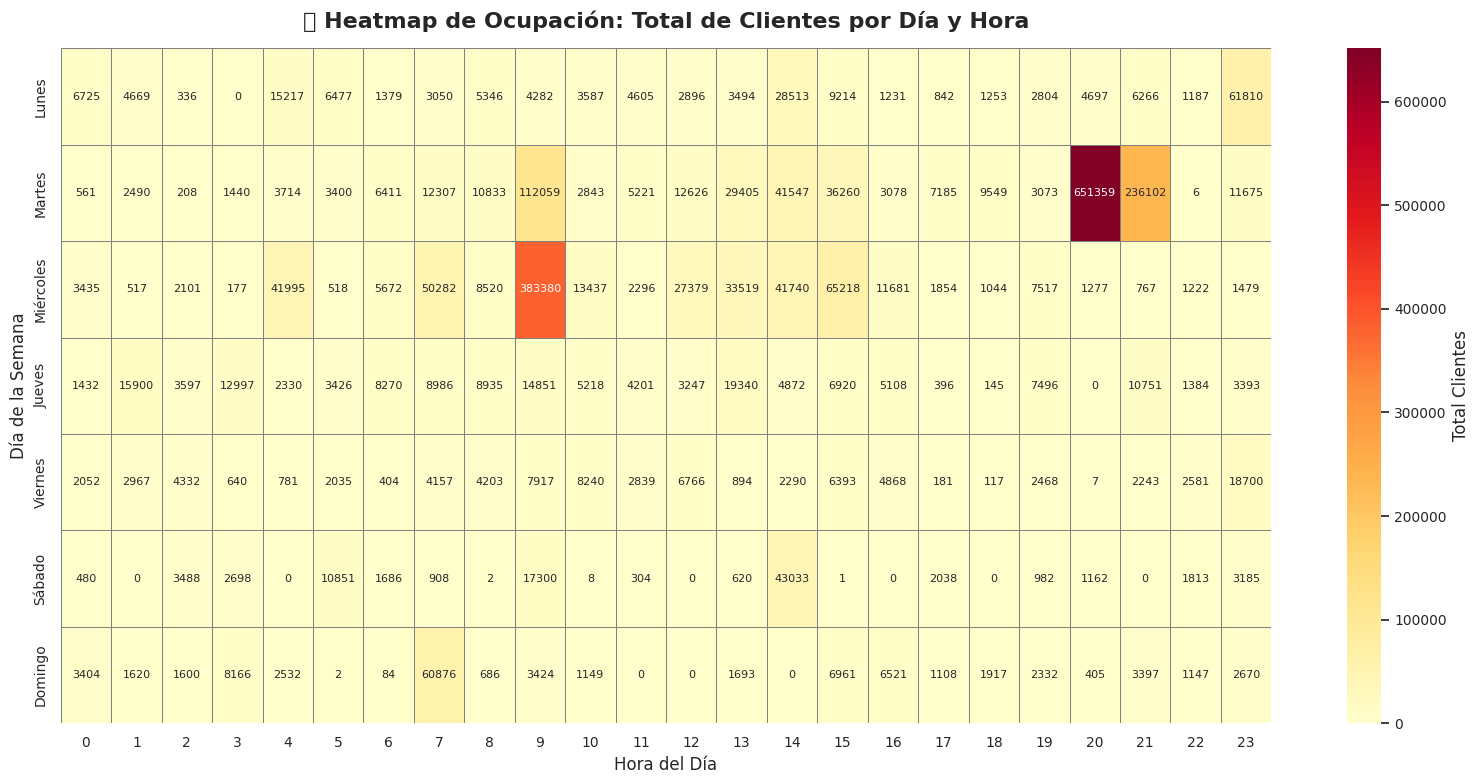


🔥 Intervalo más ocupado: Martes a las 20:00 con 651,359 clientes


In [13]:
# Crear pivot table para heatmap: día de la semana vs hora
heatmap_data = hourly_stats.pivot_table(
    values='total_clients',
    index='day_of_week',
    columns='hour',
    aggfunc='mean'
)

# Ordenar días de la semana correctamente
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = heatmap_data.reindex([day for day in day_order if day in heatmap_data.index])

# Traducir días al español (opcional)
day_names_es = {
    'Monday': 'Lunes',
    'Tuesday': 'Martes',
    'Wednesday': 'Miércoles',
    'Thursday': 'Jueves',
    'Friday': 'Viernes',
    'Saturday': 'Sábado',
    'Sunday': 'Domingo'
}
heatmap_data.index = [day_names_es.get(day, day) for day in heatmap_data.index]

# Crear heatmap
plt.figure(figsize=(16, 8))
sns.heatmap(heatmap_data, 
            annot=True, 
            fmt='.0f', 
            cmap='YlOrRd', 
            cbar_kws={'label': 'Total Clientes'},
            linewidths=0.5,
            linecolor='gray',
            annot_kws={'size': 8})
plt.title('🔥 Heatmap de Ocupación: Total de Clientes por Día y Hora', 
          fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Hora del Día', fontsize=12)
plt.ylabel('Día de la Semana', fontsize=12)
plt.tight_layout()
plt.show()

# Identificar el intervalo más ocupado
max_value = heatmap_data.max().max()
max_day = heatmap_data.max(axis=1).idxmax()
max_hour = heatmap_data.loc[max_day].idxmax()
print(f"\n🔥 Intervalo más ocupado: {max_day} a las {int(max_hour)}:00 con {max_value:,.0f} clientes")


### 4.3 Análisis por Intervalos de 15 Minutos

Análisis más detallado usando intervalos de 15 minutos para identificar patrones más granulares.


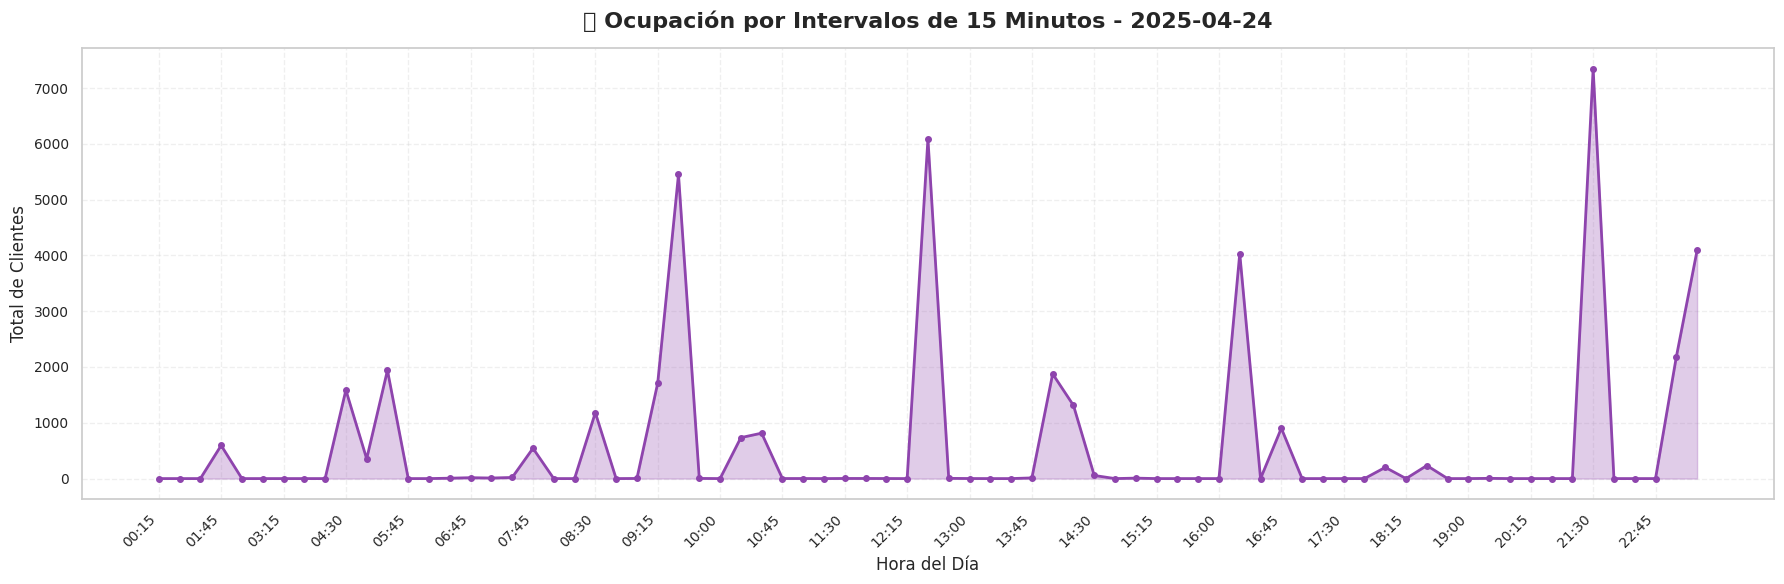


📅 Día analizado: 2025-04-24
📊 Intervalos de 15 minutos: 75
🔥 Intervalo más ocupado: 21:30 con 7,344 clientes


In [14]:
# Análisis por intervalos de 15 minutos
quarterly_stats = df_aps.groupby('time_slot_15min').agg({
    'client_count': ['sum', 'mean', 'max'],
    'ip_address': 'nunique',  # Usando IP hasheada como identificador único
    'cpu_utilization': 'mean' if 'cpu_utilization' in df_aps.columns else lambda x: 0
}).round(2)

quarterly_stats.columns = ['total_clients', 'avg_clients_per_ap', 'max_clients_single_ap', 
                           'unique_aps', 'avg_cpu_utilization']
quarterly_stats = quarterly_stats.reset_index()

# Agregar información temporal
quarterly_stats['hour'] = quarterly_stats['time_slot_15min'].dt.hour
quarterly_stats['minute'] = quarterly_stats['time_slot_15min'].dt.minute
quarterly_stats['time_str'] = quarterly_stats['time_slot_15min'].dt.strftime('%H:%M')

# Visualizar un día completo (si tenemos datos suficientes)
if len(quarterly_stats) > 0:
    # Seleccionar un día representativo (el día con más datos)
    sample_date = quarterly_stats['time_slot_15min'].dt.date.value_counts().index[0]
    daily_data = quarterly_stats[quarterly_stats['time_slot_15min'].dt.date == sample_date].copy()
    daily_data = daily_data.sort_values('time_slot_15min')
    
    # Crear etiquetas para el eje X (cada hora)
    daily_data['time_label'] = daily_data['time_slot_15min'].dt.strftime('%H:%M')
    
    fig, ax = plt.subplots(figsize=(18, 6))
    ax.plot(range(len(daily_data)), daily_data['total_clients'], 
            marker='o', linewidth=2, markersize=4, color='#8e44ad')
    ax.fill_between(range(len(daily_data)), daily_data['total_clients'], 
                     alpha=0.3, color='#9b59b6')
    ax.set_title(f'📊 Ocupación por Intervalos de 15 Minutos - {sample_date}', 
                 fontsize=16, fontweight='bold', pad=15)
    ax.set_xlabel('Hora del Día', fontsize=12)
    ax.set_ylabel('Total de Clientes', fontsize=12)
    
    # Mostrar solo algunas etiquetas para legibilidad
    step = max(1, len(daily_data) // 24)  # Aproximadamente una etiqueta por hora
    ax.set_xticks(range(0, len(daily_data), step))
    ax.set_xticklabels([daily_data.iloc[i]['time_label'] for i in range(0, len(daily_data), step)], 
                        rotation=45, ha='right')
    ax.grid(alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.show()
    
    print(f"\n📅 Día analizado: {sample_date}")
    print(f"📊 Intervalos de 15 minutos: {len(daily_data)}")
    print(f"🔥 Intervalo más ocupado: {daily_data.loc[daily_data['total_clients'].idxmax(), 'time_str']} "
          f"con {daily_data['total_clients'].max():,.0f} clientes")
else:
    print("⚠️  No hay suficientes datos para análisis por 15 minutos")


### 4.4 Estadísticas de Utilización de CPU (si disponible)

Si los datos incluyen información de CPU, analizamos la carga del sistema por intervalos.


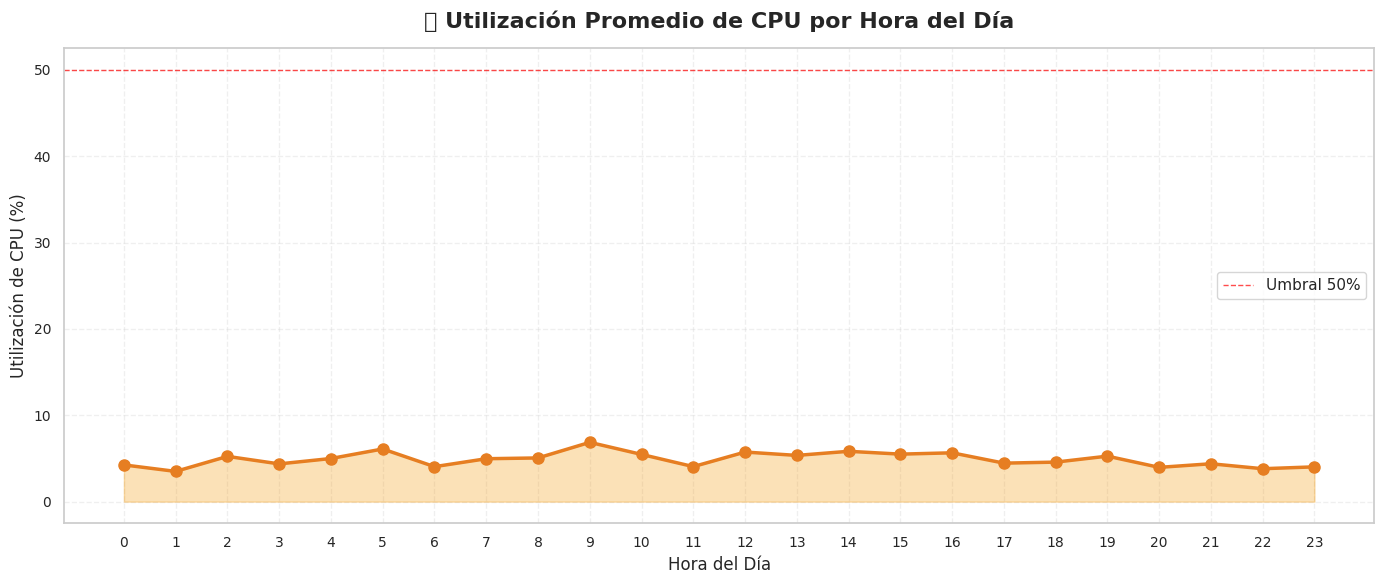


💻 Hora con mayor utilización de CPU: 9:00 (6.9%)


In [15]:
if 'cpu_utilization' in df_aps.columns and df_aps['cpu_utilization'].notna().sum() > 0:
    # Agrupar por hora y calcular estadísticas de CPU
    cpu_hourly = df_aps.groupby('time_slot_hour').agg({
        'cpu_utilization': ['mean', 'max', 'std'],
        'ip_address': 'nunique'  # Usando IP hasheada como identificador único
    }).round(2)
    
    cpu_hourly.columns = ['avg_cpu', 'max_cpu', 'std_cpu', 'unique_aps']
    cpu_hourly = cpu_hourly.reset_index()
    cpu_hourly['hour'] = cpu_hourly['time_slot_hour'].dt.hour
    
    # Promedio por hora del día
    cpu_hourly_avg = cpu_hourly.groupby('hour')['avg_cpu'].mean().reset_index()
    
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(cpu_hourly_avg['hour'], cpu_hourly_avg['avg_cpu'], 
            marker='o', linewidth=2.5, markersize=8, color='#e67e22')
    ax.fill_between(cpu_hourly_avg['hour'], cpu_hourly_avg['avg_cpu'], 
                     alpha=0.3, color='#f39c12')
    ax.set_title('💻 Utilización Promedio de CPU por Hora del Día', 
                 fontsize=16, fontweight='bold', pad=15)
    ax.set_xlabel('Hora del Día', fontsize=12)
    ax.set_ylabel('Utilización de CPU (%)', fontsize=12)
    ax.set_xticks(range(0, 24))
    ax.grid(alpha=0.3, linestyle='--')
    
    # Línea de referencia al 50%
    ax.axhline(y=50, color='red', linestyle='--', linewidth=1, 
               label='Umbral 50%', alpha=0.7)
    ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    peak_cpu_hour = cpu_hourly_avg.loc[cpu_hourly_avg['avg_cpu'].idxmax(), 'hour']
    peak_cpu_value = cpu_hourly_avg['avg_cpu'].max()
    print(f"\n💻 Hora con mayor utilización de CPU: {int(peak_cpu_hour)}:00 ({peak_cpu_value:.1f}%)")
else:
    print("ℹ️  Información de CPU no disponible en los datos")


### 4.5 Resumen de Intervalos Más y Menos Ocupados

Identificamos los intervalos con mayor y menor ocupación.


In [16]:
# Top 10 intervalos más ocupados
top_busy = hourly_stats.nlargest(10, 'total_clients')[
    ['time_slot_hour', 'total_clients', 'avg_clients_per_ap', 'unique_aps', 'day_of_week']
].copy()
top_busy['time_str'] = top_busy['time_slot_hour'].dt.strftime('%Y-%m-%d %H:%M')

# Top 10 intervalos menos ocupados
top_quiet = hourly_stats.nsmallest(10, 'total_clients')[
    ['time_slot_hour', 'total_clients', 'avg_clients_per_ap', 'unique_aps', 'day_of_week']
].copy()
top_quiet['time_str'] = top_quiet['time_slot_hour'].dt.strftime('%Y-%m-%d %H:%M')

print("🔥 TOP 10 INTERVALOS MÁS OCUPADOS:")
print("="*80)
for idx, row in top_busy.iterrows():
    print(f"{row['time_str']:20s} | {row['day_of_week']:10s} | "
          f"Clientes: {row['total_clients']:6,.0f} | "
          f"Promedio/AP: {row['avg_clients_per_ap']:5.1f} | "
          f"APs Activos: {row['unique_aps']:4.0f}")

print("\n" + "="*80)
print("😴 TOP 10 INTERVALOS MENOS OCUPADOS:")
print("="*80)
for idx, row in top_quiet.iterrows():
    print(f"{row['time_str']:20s} | {row['day_of_week']:10s} | "
          f"Clientes: {row['total_clients']:6,.0f} | "
          f"Promedio/AP: {row['avg_clients_per_ap']:5.1f} | "
          f"APs Activos: {row['unique_aps']:4.0f}")


🔥 TOP 10 INTERVALOS MÁS OCUPADOS:
2025-04-15 20:00     | Tuesday    | Clientes: 2,600,652 | Promedio/AP:   4.3 | APs Activos:  966
2025-04-02 09:00     | Wednesday  | Clientes: 1,114,571 | Promedio/AP:   3.8 | APs Activos:  261
2025-04-15 21:00     | Tuesday    | Clientes: 704,493 | Promedio/AP:   4.1 | APs Activos:  234
2025-01-21 09:00     | Tuesday    | Clientes: 648,191 | Promedio/AP:   4.0 | APs Activos:  132
2025-01-29 07:00     | Wednesday  | Clientes: 298,176 | Promedio/AP:   3.2 | APs Activos:   73
2025-04-02 15:00     | Wednesday  | Clientes: 251,844 | Promedio/AP:   7.1 | APs Activos:   29
2025-04-02 14:00     | Wednesday  | Clientes: 200,826 | Promedio/AP:   7.2 | APs Activos:   23
2025-01-26 07:00     | Sunday     | Clientes: 176,836 | Promedio/AP:   4.8 | APs Activos:   30
2025-03-31 14:00     | Monday     | Clientes: 170,297 | Promedio/AP:   7.1 | APs Activos:   19
2025-04-01 14:00     | Tuesday    | Clientes: 164,866 | Promedio/AP:   5.0 | APs Activos:   27

😴 TOP 10 IN

ly

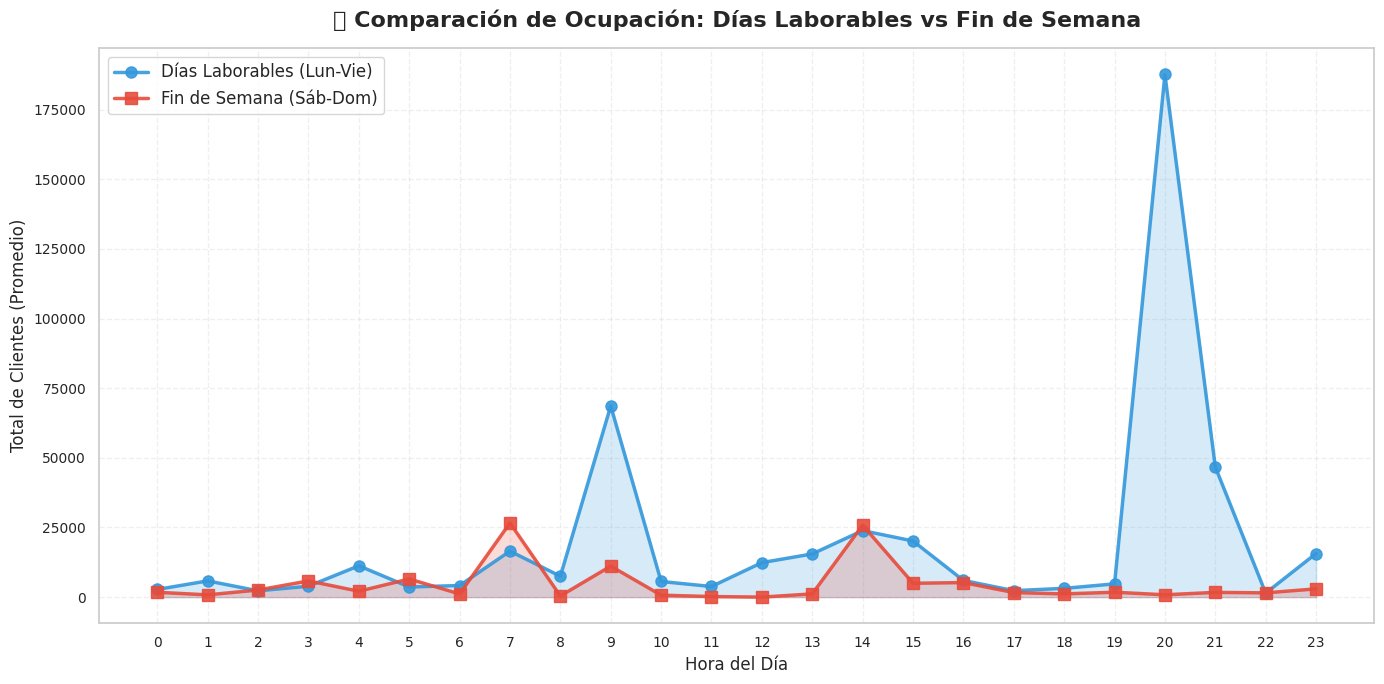


📅 Días Laborables - Hora pico: 20:00 (187,628 clientes)
🎉 Fin de Semana - Hora pico: 7:00 (26,609 clientes)
📊 Diferencia: 161,019 clientes (85.8% menos en fin de semana)


In [17]:
# Clasificar días en laborables y fin de semana
hourly_stats['is_weekend'] = hourly_stats['day_of_week'].isin(['Saturday', 'Sunday'])

# Agrupar por tipo de día y hora
weekday_weekend = hourly_stats.groupby(['is_weekend', 'hour']).agg({
    'total_clients': 'mean',
    'avg_clients_per_ap': 'mean',
    'unique_aps': 'mean'
}).reset_index()

weekday_data = weekday_weekend[weekday_weekend['is_weekend'] == False]
weekend_data = weekday_weekend[weekday_weekend['is_weekend'] == True]

# Visualización comparativa
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(weekday_data['hour'], weekday_data['total_clients'], 
        marker='o', linewidth=2.5, markersize=8, color='#3498db', 
        label='Días Laborables (Lun-Vie)', alpha=0.9)
ax.fill_between(weekday_data['hour'], weekday_data['total_clients'], 
                alpha=0.2, color='#3498db')

if len(weekend_data) > 0:
    ax.plot(weekend_data['hour'], weekend_data['total_clients'], 
            marker='s', linewidth=2.5, markersize=8, color='#e74c3c', 
            label='Fin de Semana (Sáb-Dom)', alpha=0.9)
    ax.fill_between(weekend_data['hour'], weekend_data['total_clients'], 
                    alpha=0.2, color='#e74c3c')

ax.set_title('📊 Comparación de Ocupación: Días Laborables vs Fin de Semana', 
             fontsize=16, fontweight='bold', pad=15)
ax.set_xlabel('Hora del Día', fontsize=12)
ax.set_ylabel('Total de Clientes (Promedio)', fontsize=12)
ax.set_xticks(range(0, 24))
ax.grid(alpha=0.3, linestyle='--')
ax.legend(fontsize=12, loc='best')
plt.tight_layout()
plt.show()

if len(weekday_data) > 0:
    weekday_peak = weekday_data.loc[weekday_data['total_clients'].idxmax(), 'hour']
    weekday_peak_value = weekday_data['total_clients'].max()
    print(f"\n📅 Días Laborables - Hora pico: {int(weekday_peak)}:00 ({weekday_peak_value:,.0f} clientes)")

if len(weekend_data) > 0:
    weekend_peak = weekend_data.loc[weekend_data['total_clients'].idxmax(), 'hour']
    weekend_peak_value = weekend_data['total_clients'].max()
    print(f"🎉 Fin de Semana - Hora pico: {int(weekend_peak)}:00 ({weekend_peak_value:,.0f} clientes)")
    
    if len(weekday_data) > 0:
        diff = weekday_peak_value - weekend_peak_value
        pct_diff = (diff / weekday_peak_value) * 100
        print(f"📊 Diferencia: {diff:,.0f} clientes ({pct_diff:.1f}% menos en fin de semana)")


## 🔍 4.7 Detección y Análisis de Picos (Peaks)

Identificamos intervalos con valores anormalmente altos y analizamos qué factores pueden explicarlos.


In [18]:
# Filtrar datos solo del mes de abril (3-29 de abril 2025)
april_start = pd.to_datetime('2025-04-03')
april_end = pd.to_datetime('2025-04-30')
df_aps_april = df_aps[(df_aps['timestamp'] >= april_start) & (df_aps['timestamp'] < april_end)].copy()

print(f"📅 Datos de abril cargados: {len(df_aps_april):,} registros")
print(f"   Rango: {df_aps_april['timestamp'].min()} a {df_aps_april['timestamp'].max()}")

# Recalcular estadísticas por hora solo para abril
# Nota: ip_address es el identificador único de cada AP (IP hasheada para privacidad)
hourly_stats_april = df_aps_april.groupby('time_slot_hour').agg({
    'client_count': ['sum', 'mean', 'max', 'std'],
    'ip_address': 'nunique',  # Usando IP hasheada como identificador único
    'cpu_utilization': 'mean' if 'cpu_utilization' in df_aps_april.columns else lambda x: 0
}).round(2)

hourly_stats_april.columns = ['total_clients', 'avg_clients_per_ap', 'max_clients_single_ap', 
                               'std_clients', 'unique_aps', 'avg_cpu_utilization']
hourly_stats_april = hourly_stats_april.reset_index()
hourly_stats_april['hour'] = hourly_stats_april['time_slot_hour'].dt.hour
hourly_stats_april['date'] = hourly_stats_april['time_slot_hour'].dt.date
hourly_stats_april['day_of_week'] = hourly_stats_april['time_slot_hour'].dt.day_name()

print(f"\n📊 Intervalos únicos en abril: {len(hourly_stats_april)}")


📅 Datos de abril cargados: 1,304,316 registros
   Rango: 2025-04-03 00:05:47 a 2025-04-29 12:56:59

📊 Intervalos únicos en abril: 441


In [19]:
# Detectar picos usando método estadístico (valores que están más de 2 desviaciones estándar por encima de la media)
mean_clients = hourly_stats_april['total_clients'].mean()
std_clients = hourly_stats_april['total_clients'].std()
threshold = mean_clients + (2 * std_clients)  # Umbral para considerar un pico

# También identificar los top N picos absolutos
top_n_peaks = 20
peaks_absolute = hourly_stats_april.nlargest(top_n_peaks, 'total_clients').copy()
peaks_statistical = hourly_stats_april[hourly_stats_april['total_clients'] > threshold].copy()

print("="*80)
print("🔍 DETECCIÓN DE PICOS")
print("="*80)
print(f"\n📊 Estadísticas base:")
print(f"   Media: {mean_clients:,.0f} clientes")
print(f"   Desviación estándar: {std_clients:,.0f} clientes")
print(f"   Umbral (media + 2σ): {threshold:,.0f} clientes")
print(f"\n🔥 Picos detectados:")
print(f"   - Top {top_n_peaks} picos absolutos: {len(peaks_absolute)}")
print(f"   - Picos estadísticos (> umbral): {len(peaks_statistical)}")

# Mostrar los top picos
print(f"\n{'='*80}")
print(f"🔥 TOP {top_n_peaks} PICOS ABSOLUTOS:")
print("="*80)
peaks_absolute['time_str'] = peaks_absolute['time_slot_hour'].dt.strftime('%Y-%m-%d %H:%M')
for idx, row in peaks_absolute.iterrows():
    print(f"{row['time_str']:20s} | {row['day_of_week']:10s} | "
          f"Clientes: {row['total_clients']:10,.0f} | "
          f"APs: {row['unique_aps']:4.0f} | "
          f"Promedio/AP: {row['avg_clients_per_ap']:6.1f}")


🔍 DETECCIÓN DE PICOS

📊 Estadísticas base:
   Media: 10,421 clientes
   Desviación estándar: 128,555 clientes
   Umbral (media + 2σ): 267,531 clientes

🔥 Picos detectados:
   - Top 20 picos absolutos: 20
   - Picos estadísticos (> umbral): 2

🔥 TOP 20 PICOS ABSOLUTOS:
2025-04-15 20:00     | Tuesday    | Clientes:  2,600,652 | APs:  966 | Promedio/AP:    4.3
2025-04-15 21:00     | Tuesday    | Clientes:    704,493 | APs:  234 | Promedio/AP:    4.1
2025-04-05 14:00     | Saturday   | Clientes:    128,866 | APs:   18 | Promedio/AP:    8.0
2025-04-28 23:00     | Monday     | Clientes:    123,619 | APs: 1041 | Promedio/AP:    1.5
2025-04-16 04:00     | Wednesday  | Clientes:    119,266 | APs:   40 | Promedio/AP:    4.1
2025-04-03 03:00     | Thursday   | Clientes:     48,124 | APs:   14 | Promedio/AP:    1.9
2025-04-15 23:00     | Tuesday    | Clientes:     41,930 | APs:   11 | Promedio/AP:    5.3
2025-04-03 09:00     | Thursday   | Clientes:     35,386 | APs:    4 | Promedio/AP:    6.3
202

### 4.7.1 Análisis Detallado de Picos: ¿Por qué ocurren?

Para cada pico, analizamos múltiples campos del AP JSON para entender qué puede estar causando estos valores extremos.


In [20]:
# Función para analizar un intervalo de tiempo específico
def analyze_peak_interval(df_aps_data, time_slot):
    """Analiza un intervalo específico y retorna métricas detalladas"""
    interval_data = df_aps_data[df_aps_data['time_slot_hour'] == time_slot].copy()
    
    if len(interval_data) == 0:
        return None
    
    analysis = {
        'time_slot': time_slot,
        'total_clients': interval_data['client_count'].sum(),
        'num_aps': interval_data['ip_address'].nunique(),  # Usando IP hasheada como identificador único
        'avg_clients_per_ap': interval_data['client_count'].mean(),
        'max_clients_single_ap': interval_data['client_count'].max(),
        'median_clients_per_ap': interval_data['client_count'].median(),
    }
    
    # Análisis de CPU
    if 'cpu_utilization' in interval_data.columns:
        analysis['avg_cpu'] = interval_data['cpu_utilization'].mean()
        analysis['max_cpu'] = interval_data['cpu_utilization'].max()
        analysis['high_cpu_aps'] = (interval_data['cpu_utilization'] > 50).sum()
    
    # Análisis de memoria
    if 'mem_free' in interval_data.columns and 'mem_total' in interval_data.columns:
        interval_data['mem_used'] = interval_data['mem_total'] - interval_data['mem_free']
        interval_data['mem_usage_pct'] = (interval_data['mem_used'] / interval_data['mem_total']) * 100
        analysis['avg_mem_usage_pct'] = interval_data['mem_usage_pct'].mean()
        analysis['high_mem_aps'] = (interval_data['mem_usage_pct'] > 80).sum()
    
    # Análisis por grupo/zona
    if 'group_name' in interval_data.columns:
        group_stats = interval_data.groupby('group_name').agg({
            'client_count': 'sum',
            'ip_address': 'nunique'  # Usando IP hasheada como identificador único
        }).sort_values('client_count', ascending=False)
        analysis['top_groups'] = group_stats.head(5).to_dict('index')
    
    # Análisis por gateway cluster
    if 'gateway_cluster_name' in interval_data.columns:
        gateway_stats = interval_data.groupby('gateway_cluster_name').agg({
            'client_count': 'sum',
            'ip_address': 'nunique'  # Usando IP hasheada como identificador único
        }).sort_values('client_count', ascending=False)
        analysis['top_gateways'] = gateway_stats.head(5).to_dict('index')
    
    # Análisis de estado de APs
    if 'status' in interval_data.columns:
        status_counts = interval_data['status'].value_counts().to_dict()
        analysis['ap_status'] = status_counts
    
    # Análisis de firmware
    if 'firmware_version' in interval_data.columns:
        firmware_counts = interval_data['firmware_version'].value_counts().head(3).to_dict()
        analysis['top_firmware'] = firmware_counts
    
    # APs con más clientes (usando IP hasheada como identificador único)
    # Agrupar por IP para obtener el total de clientes por AP único
    ap_summary = interval_data.groupby('ip_address').agg({
        'client_count': 'sum',
        'name': 'first',  # Tomar el nombre para display (puede haber múltiples registros con mismo IP)
        'cpu_utilization': 'mean' if 'cpu_utilization' in interval_data.columns else lambda x: 0
    }).reset_index()
    
    top_aps_cols = ['ip_address', 'name', 'client_count']
    if 'cpu_utilization' in ap_summary.columns:
        top_aps_cols.append('cpu_utilization')
    top_aps = ap_summary.nlargest(10, 'client_count')[top_aps_cols].to_dict('records')
    analysis['top_aps'] = top_aps
    
    return analysis

# Analizar los top 5 picos
print("="*80)
print("📋 ANÁLISIS DETALLADO DE TOP 5 PICOS")
print("="*80)

peak_analyses = []
for idx, peak_row in peaks_absolute.head(5).iterrows():
    time_slot = peak_row['time_slot_hour']
    analysis = analyze_peak_interval(df_aps_april, time_slot)
    if analysis:
        peak_analyses.append(analysis)
        
        print(f"\n{'='*80}")
        print(f"🔥 PICO #{len(peak_analyses)}: {time_slot.strftime('%Y-%m-%d %H:%M')} ({peak_row['day_of_week']})")
        print("="*80)
        print(f"📊 Métricas Generales:")
        print(f"   Total Clientes: {analysis['total_clients']:,.0f}")
        print(f"   Número de APs: {analysis['num_aps']}")
        print(f"   Promedio Clientes/AP: {analysis['avg_clients_per_ap']:.1f}")
        print(f"   Mediana Clientes/AP: {analysis['median_clients_per_ap']:.1f}")
        print(f"   Máximo en un solo AP: {analysis['max_clients_single_ap']}")
        
        if 'avg_cpu' in analysis:
            print(f"\n💻 CPU:")
            print(f"   Promedio: {analysis['avg_cpu']:.1f}%")
            print(f"   Máximo: {analysis['max_cpu']:.1f}%")
            print(f"   APs con CPU > 50%: {analysis['high_cpu_aps']}")
        
        if 'avg_mem_usage_pct' in analysis:
            print(f"\n💾 Memoria:")
            print(f"   Uso promedio: {analysis['avg_mem_usage_pct']:.1f}%")
            print(f"   APs con memoria > 80%: {analysis['high_mem_aps']}")
        
        if 'top_groups' in analysis and analysis['top_groups']:
            print(f"\n🏢 Top Grupos/Zonas:")
            for group, stats in list(analysis['top_groups'].items())[:3]:
                print(f"   {group}: {stats['client_count']:,.0f} clientes ({stats['ip_address']} APs únicos)")
        
        if 'top_gateways' in analysis and analysis['top_gateways']:
            print(f"\n🌐 Top Gateway Clusters:")
            for gateway, stats in list(analysis['top_gateways'].items())[:3]:
                print(f"   {gateway}: {stats['client_count']:,.0f} clientes ({stats['ip_address']} APs únicos)")
        
        if 'top_aps' in analysis:
            print(f"\n📡 Top 5 APs con más clientes (identificados por IP hasheada):")
            for ap in analysis['top_aps'][:5]:
                cpu_str = f", CPU: {ap.get('cpu_utilization', 'N/A'):.1f}%" if 'cpu_utilization' in ap and ap.get('cpu_utilization') else ""
                name_str = f" ({ap.get('name', 'N/A')})" if 'name' in ap else ""
                print(f"   IP: {ap['ip_address']}{name_str}: {ap['client_count']} clientes{cpu_str}")


📋 ANÁLISIS DETALLADO DE TOP 5 PICOS

🔥 PICO #1: 2025-04-15 20:00 (Tuesday)
📊 Métricas Generales:
   Total Clientes: 2,600,652
   Número de APs: 966
   Promedio Clientes/AP: 4.3
   Mediana Clientes/AP: 1.0
   Máximo en un solo AP: 159

💻 CPU:
   Promedio: 6.4%
   Máximo: 90.0%
   APs con CPU > 50%: 8737

💾 Memoria:
   Uso promedio: 63.4%
   APs con memoria > 80%: 1061

🏢 Top Grupos/Zonas:
   Bellaterra: 2,600,652 clientes (966 APs únicos)

🌐 Top Gateway Clusters:
   auto_group_229: 1,993,169 clientes (757 APs únicos)
   : 607,483 clientes (433 APs únicos)

📡 Top 5 APs con más clientes (identificados por IP hasheada):
   IP: IP_68e571dcb44d (AP-BIBSOC08): 20799 clientes, CPU: 37.4%
   IP: IP_8bcbcaa83367 (AP-BIBCIE01): 20138 clientes, CPU: 5.3%
   IP: IP_fd0a1bf86874 (AP-CIVIC08): 17363 clientes, CPU: 11.7%
   IP: IP_e17888db92dc (AP-ECON23): 16273 clientes, CPU: 18.8%
   IP: IP_6cf7b1353ec7 (AP-CIEN08): 15828 clientes, CPU: 67.5%

🔥 PICO #2: 2025-04-15 21:00 (Tuesday)
📊 Métricas General

### 4.7.2 Visualización del Mes Completo (Abril 2025)

Visualizaciones que muestran toda la actividad del mes de abril.


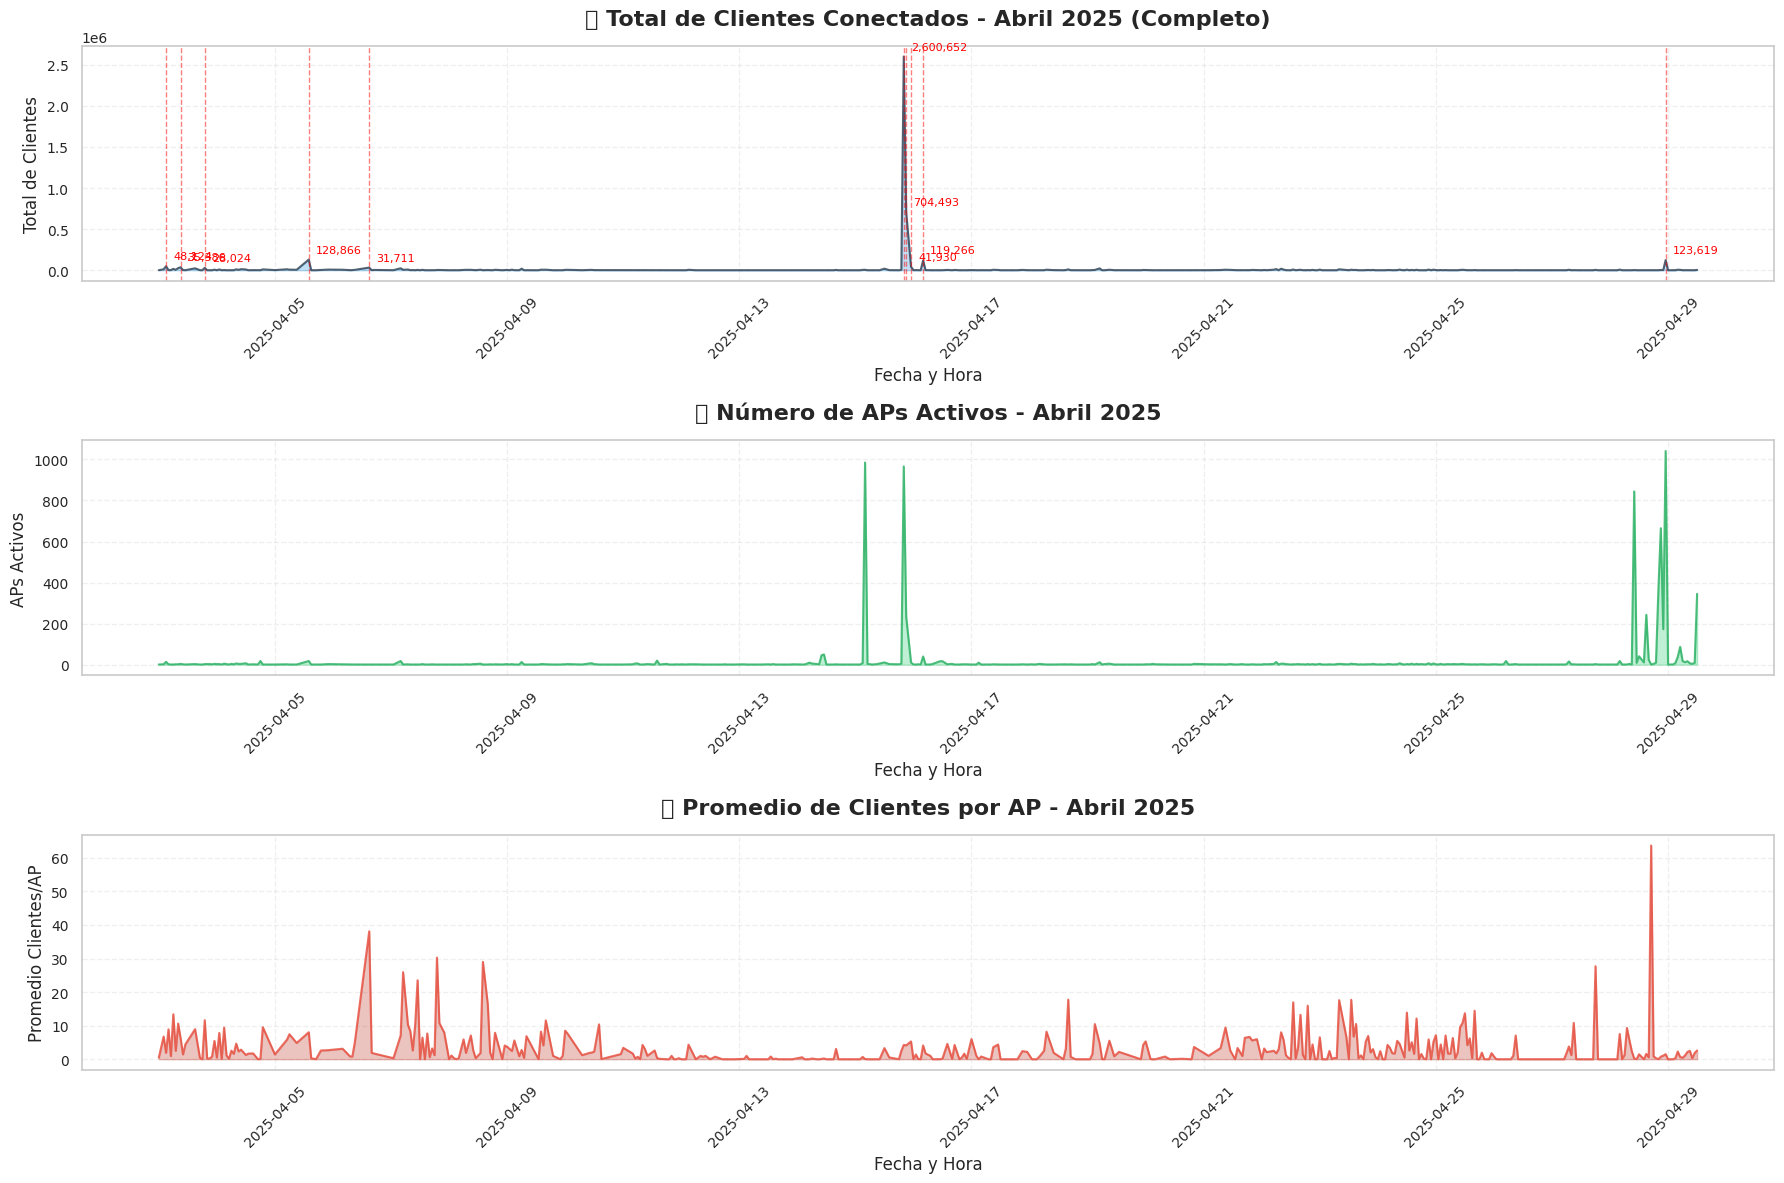


📊 Visualización completa del mes de abril generada
   Total de intervalos: 441
   Picos marcados: 10


In [21]:
# Visualización 1: Serie temporal completa del mes
fig, axes = plt.subplots(3, 1, figsize=(18, 12))

# Gráfico 1: Total de clientes a lo largo del mes
hourly_stats_april_sorted = hourly_stats_april.sort_values('time_slot_hour')
axes[0].plot(hourly_stats_april_sorted['time_slot_hour'], hourly_stats_april_sorted['total_clients'], 
             linewidth=1.5, color='#2c3e50', alpha=0.8)
axes[0].fill_between(hourly_stats_april_sorted['time_slot_hour'], hourly_stats_april_sorted['total_clients'], 
                      alpha=0.3, color='#3498db')

# Marcar picos
for peak_row in peaks_absolute.head(10).itertuples():
    axes[0].axvline(x=peak_row.time_slot_hour, color='red', linestyle='--', alpha=0.5, linewidth=1)
    axes[0].annotate(f"{peak_row.total_clients:,.0f}", 
                     xy=(peak_row.time_slot_hour, peak_row.total_clients),
                     xytext=(5, 5), textcoords='offset points', fontsize=8, color='red')

axes[0].set_title('📊 Total de Clientes Conectados - Abril 2025 (Completo)', 
                  fontsize=16, fontweight='bold', pad=15)
axes[0].set_xlabel('Fecha y Hora', fontsize=12)
axes[0].set_ylabel('Total de Clientes', fontsize=12)
axes[0].grid(alpha=0.3, linestyle='--')
axes[0].tick_params(axis='x', rotation=45)

# Gráfico 2: Número de APs activos
axes[1].plot(hourly_stats_april_sorted['time_slot_hour'], hourly_stats_april_sorted['unique_aps'], 
             linewidth=1.5, color='#27ae60', alpha=0.8)
axes[1].fill_between(hourly_stats_april_sorted['time_slot_hour'], hourly_stats_april_sorted['unique_aps'], 
                      alpha=0.3, color='#2ecc71')
axes[1].set_title('📡 Número de APs Activos - Abril 2025', 
                  fontsize=16, fontweight='bold', pad=15)
axes[1].set_xlabel('Fecha y Hora', fontsize=12)
axes[1].set_ylabel('APs Activos', fontsize=12)
axes[1].grid(alpha=0.3, linestyle='--')
axes[1].tick_params(axis='x', rotation=45)

# Gráfico 3: Promedio de clientes por AP
axes[2].plot(hourly_stats_april_sorted['time_slot_hour'], hourly_stats_april_sorted['avg_clients_per_ap'], 
             linewidth=1.5, color='#e74c3c', alpha=0.8)
axes[2].fill_between(hourly_stats_april_sorted['time_slot_hour'], hourly_stats_april_sorted['avg_clients_per_ap'], 
                      alpha=0.3, color='#c0392b')
axes[2].set_title('📊 Promedio de Clientes por AP - Abril 2025', 
                  fontsize=16, fontweight='bold', pad=15)
axes[2].set_xlabel('Fecha y Hora', fontsize=12)
axes[2].set_ylabel('Promedio Clientes/AP', fontsize=12)
axes[2].grid(alpha=0.3, linestyle='--')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print(f"\n📊 Visualización completa del mes de abril generada")
print(f"   Total de intervalos: {len(hourly_stats_april)}")
print(f"   Picos marcados: {len(peaks_absolute.head(10))}")


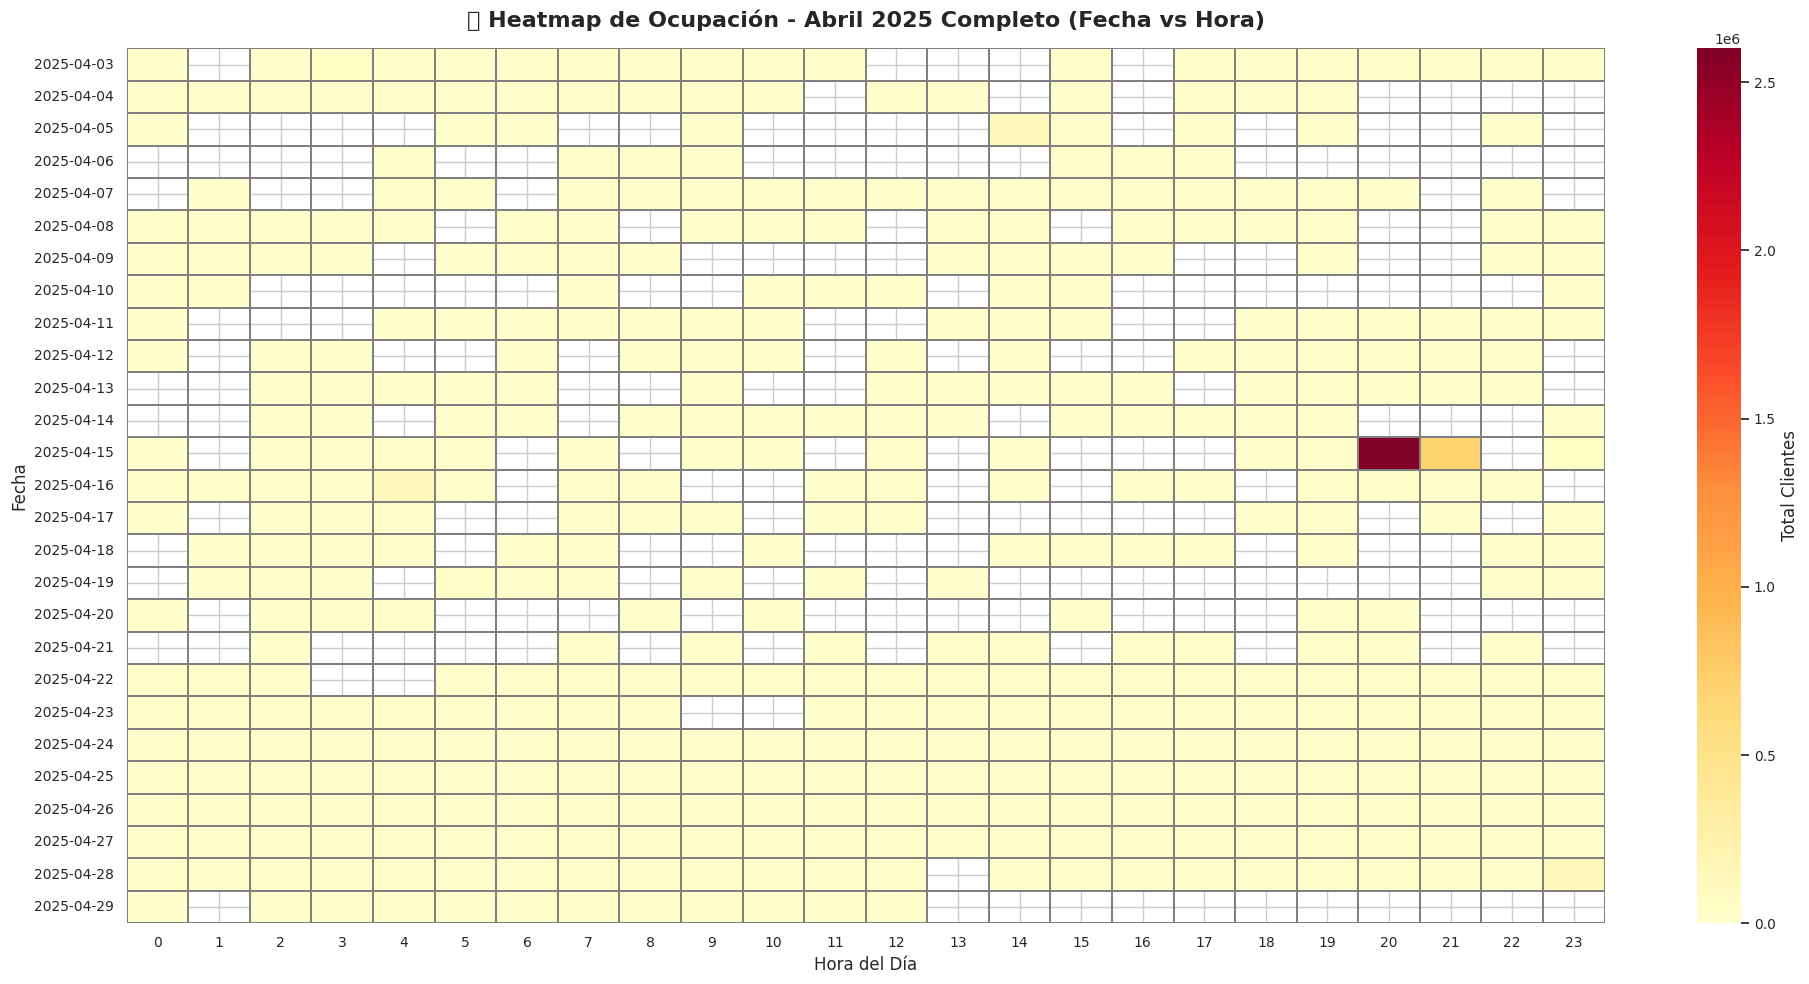


📅 Top 5 días más ocupados en abril:
   2025-04-15 (Tuesday): 3,379,231 clientes
   2025-04-03 (Thursday): 202,249 clientes
   2025-04-05 (Saturday): 163,247 clientes
   2025-04-28 (Monday): 139,117 clientes
   2025-04-16 (Wednesday): 129,942 clientes


In [22]:
# Visualización 2: Heatmap del mes completo (día vs hora)
# Crear pivot table: fecha vs hora
heatmap_month = hourly_stats_april.pivot_table(
    values='total_clients',
    index=hourly_stats_april['time_slot_hour'].dt.date,
    columns=hourly_stats_april['time_slot_hour'].dt.hour,
    aggfunc='sum'
)

# Ordenar por fecha
heatmap_month = heatmap_month.sort_index()

# Crear heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(heatmap_month, 
            annot=False,  # Desactivar anotaciones para legibilidad
            fmt='.0f', 
            cmap='YlOrRd', 
            cbar_kws={'label': 'Total Clientes'},
            linewidths=0.1,
            linecolor='gray')
plt.title('🔥 Heatmap de Ocupación - Abril 2025 Completo (Fecha vs Hora)', 
          fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Hora del Día', fontsize=12)
plt.ylabel('Fecha', fontsize=12)
plt.tight_layout()
plt.show()

# Identificar días más ocupados
daily_totals = heatmap_month.sum(axis=1).sort_values(ascending=False)
print(f"\n📅 Top 5 días más ocupados en abril:")
for date, total in daily_totals.head(5).items():
    day_name = pd.to_datetime(date).strftime('%A')
    print(f"   {date} ({day_name}): {total:,.0f} clientes")


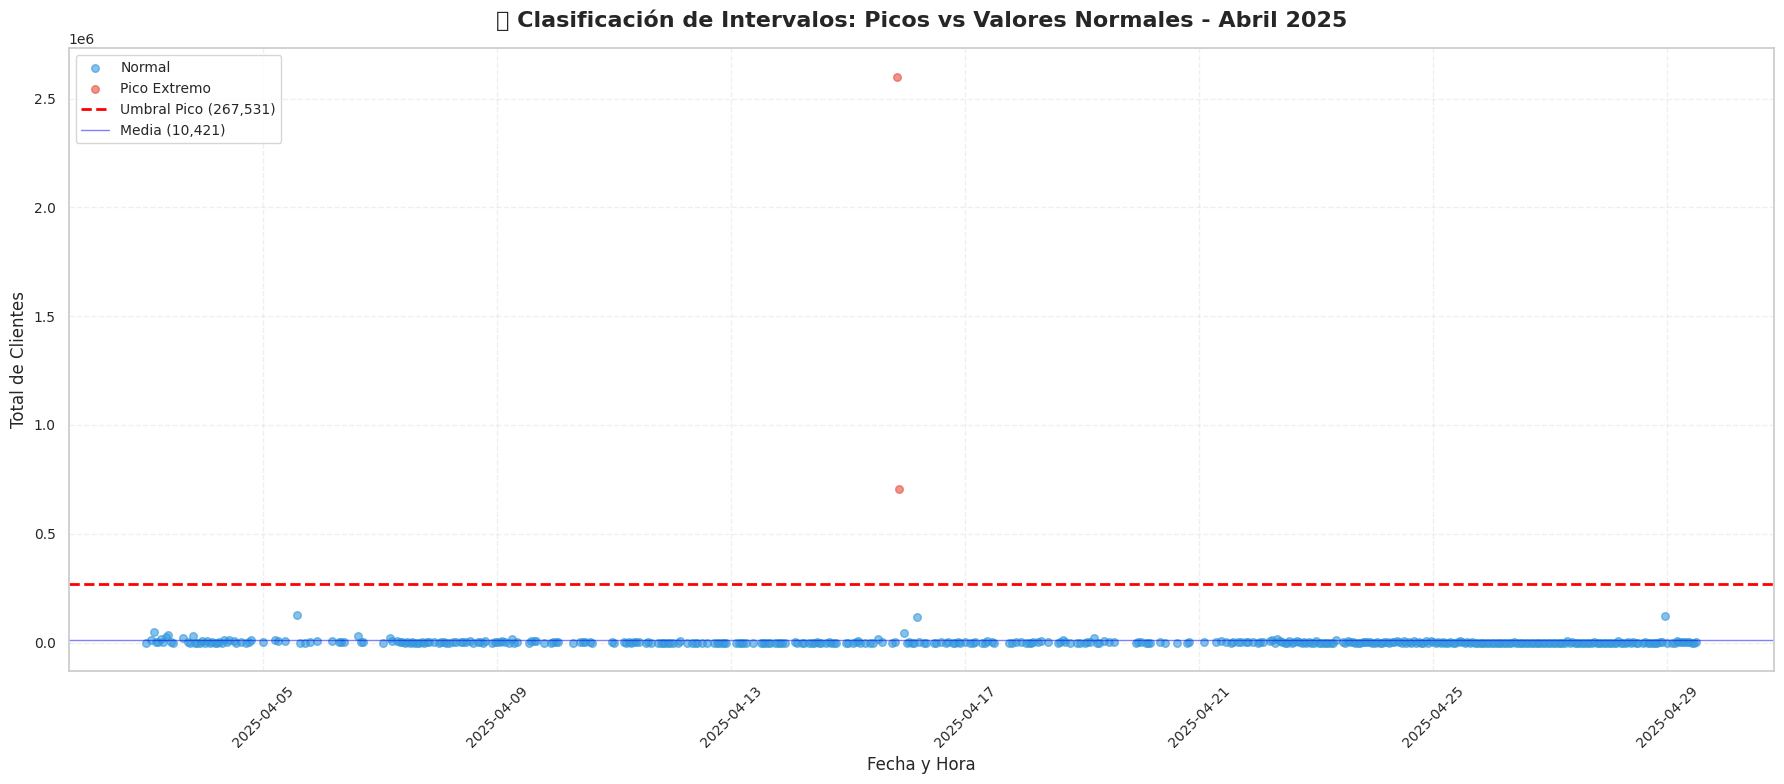


📊 Distribución de intervalos por categoría:
   Normal: 439 intervalos (99.5%)
   Pico Extremo: 2 intervalos (0.5%)


In [23]:
# Visualización 3: Comparación de picos vs valores normales
# Definir valores "normales" (media ± 1 desviación estándar)
normal_lower = mean_clients - std_clients
normal_upper = mean_clients + std_clients

# Clasificar intervalos
hourly_stats_april['peak_category'] = 'Normal'
hourly_stats_april.loc[hourly_stats_april['total_clients'] > threshold, 'peak_category'] = 'Pico Extremo'
hourly_stats_april.loc[
    (hourly_stats_april['total_clients'] > normal_upper) & 
    (hourly_stats_april['total_clients'] <= threshold), 
    'peak_category'
] = 'Alto'
hourly_stats_april.loc[hourly_stats_april['total_clients'] < normal_lower, 'peak_category'] = 'Bajo'

# Crear visualización comparativa
fig, ax = plt.subplots(figsize=(18, 8))

colors = {'Normal': '#3498db', 'Alto': '#f39c12', 'Pico Extremo': '#e74c3c', 'Bajo': '#95a5a6'}
for category in ['Bajo', 'Normal', 'Alto', 'Pico Extremo']:
    data = hourly_stats_april[hourly_stats_april['peak_category'] == category]
    if len(data) > 0:
        ax.scatter(data['time_slot_hour'], data['total_clients'], 
                  label=category, color=colors[category], alpha=0.6, s=30)

ax.axhline(y=threshold, color='red', linestyle='--', linewidth=2, label=f'Umbral Pico ({threshold:,.0f})')
ax.axhline(y=mean_clients, color='blue', linestyle='-', linewidth=1, alpha=0.5, label=f'Media ({mean_clients:,.0f})')
ax.set_title('📊 Clasificación de Intervalos: Picos vs Valores Normales - Abril 2025', 
             fontsize=16, fontweight='bold', pad=15)
ax.set_xlabel('Fecha y Hora', fontsize=12)
ax.set_ylabel('Total de Clientes', fontsize=12)
ax.legend(loc='upper left', fontsize=10)
ax.grid(alpha=0.3, linestyle='--')
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

# Estadísticas por categoría
print("\n📊 Distribución de intervalos por categoría:")
category_stats = hourly_stats_april['peak_category'].value_counts()
for category, count in category_stats.items():
    pct = (count / len(hourly_stats_april)) * 100
    print(f"   {category}: {count} intervalos ({pct:.1f}%)")


### 4.7.3 Resumen de Factores que Explican los Picos

Analizamos correlaciones y patrones comunes en los picos detectados.


In [24]:
# Análisis de patrones en los picos
print("="*80)
print("🔍 ANÁLISIS DE PATRONES EN LOS PICOS")
print("="*80)

# 1. Distribución por día de la semana
if len(peaks_absolute) > 0:
    peak_days = peaks_absolute['day_of_week'].value_counts()
    print(f"\n📅 Distribución de picos por día de la semana:")
    for day, count in peak_days.items():
        pct = (count / len(peaks_absolute)) * 100
        print(f"   {day}: {count} picos ({pct:.1f}%)")

# 2. Distribución por hora
if len(peaks_absolute) > 0:
    peak_hours = peaks_absolute['hour'].value_counts().sort_index()
    print(f"\n⏰ Distribución de picos por hora del día:")
    for hour, count in peak_hours.items():
        pct = (count / len(peaks_absolute)) * 100
        print(f"   {hour:02d}:00: {count} picos ({pct:.1f}%)")

# 3. Correlación con número de APs
if len(peaks_absolute) > 0:
    correlation_aps = peaks_absolute['total_clients'].corr(peaks_absolute['unique_aps'])
    print(f"\n📡 Correlación entre total de clientes y número de APs en picos:")
    print(f"   Coeficiente de correlación: {correlation_aps:.3f}")
    if correlation_aps > 0.7:
        print("   ✅ Alta correlación: Los picos están relacionados con más APs activos")
    elif correlation_aps > 0.3:
        print("   ℹ️  Correlación moderada")
    else:
        print("   ⚠️  Baja correlación: Los picos NO están principalmente causados por más APs")

# 4. Comparar métricas promedio en picos vs normales
normal_intervals = hourly_stats_april[hourly_stats_april['peak_category'] == 'Normal']
peak_intervals = hourly_stats_april[hourly_stats_april['peak_category'] == 'Pico Extremo']

if len(normal_intervals) > 0 and len(peak_intervals) > 0:
    print(f"\n📊 Comparación: Intervalos Normales vs Picos Extremos")
    print(f"{'Métrica':<30} {'Normal':<20} {'Pico Extremo':<20} {'Diferencia':<20}")
    print("-" * 90)
    
    metrics = [
        ('Promedio Clientes/AP', 'avg_clients_per_ap'),
        ('APs Activos', 'unique_aps'),
    ]
    
    if 'avg_cpu_utilization' in normal_intervals.columns:
        metrics.append(('CPU Promedio (%)', 'avg_cpu_utilization'))
    
    for label, col in metrics:
        normal_val = normal_intervals[col].mean()
        peak_val = peak_intervals[col].mean()
        diff = peak_val - normal_val
        diff_pct = (diff / normal_val * 100) if normal_val > 0 else 0
        
        print(f"{label:<30} {normal_val:<20.2f} {peak_val:<20.2f} {diff:+.2f} ({diff_pct:+.1f}%)")

# 5. Análisis de fechas específicas con picos
if len(peaks_absolute) > 0:
    peak_dates = peaks_absolute['date'].value_counts().head(5)
    print(f"\n📅 Fechas con más picos:")
    for date, count in peak_dates.items():
        day_name = pd.to_datetime(date).strftime('%A')
        print(f"   {date} ({day_name}): {count} picos")


🔍 ANÁLISIS DE PATRONES EN LOS PICOS

📅 Distribución de picos por día de la semana:
   Tuesday: 6 picos (30.0%)
   Thursday: 6 picos (30.0%)
   Saturday: 2 picos (10.0%)
   Monday: 2 picos (10.0%)
   Wednesday: 2 picos (10.0%)
   Sunday: 1 picos (5.0%)
   Friday: 1 picos (5.0%)

⏰ Distribución de picos por hora del día:
   03:00: 1 picos (5.0%)
   04:00: 2 picos (10.0%)
   05:00: 1 picos (5.0%)
   06:00: 3 picos (15.0%)
   08:00: 2 picos (10.0%)
   09:00: 1 picos (5.0%)
   10:00: 1 picos (5.0%)
   12:00: 1 picos (5.0%)
   14:00: 1 picos (5.0%)
   15:00: 2 picos (10.0%)
   19:00: 1 picos (5.0%)
   20:00: 1 picos (5.0%)
   21:00: 1 picos (5.0%)
   23:00: 2 picos (10.0%)

📡 Correlación entre total de clientes y número de APs en picos:
   Coeficiente de correlación: 0.684
   ℹ️  Correlación moderada

📊 Comparación: Intervalos Normales vs Picos Extremos
Métrica                        Normal               Pico Extremo         Diferencia          
----------------------------------------------

## 📈 5. Resumen y Conclusiones

### Métricas Clave Identificadas:


In [25]:
# Calcular estadísticas generales
total_intervals = len(hourly_stats)
avg_clients_per_interval = hourly_stats['total_clients'].mean()
max_clients_interval = hourly_stats['total_clients'].max()
min_clients_interval = hourly_stats['total_clients'].min()
std_clients = hourly_stats['total_clients'].std()

print("="*70)
print("📊 RESUMEN DE ANÁLISIS DE OCUPACIÓN POR INTERVALOS")
print("="*70)
print(f"\n📅 Intervalos analizados: {total_intervals:,}")
print(f"📊 Promedio de clientes por intervalo: {avg_clients_per_interval:,.0f}")
print(f"🔥 Máximo de clientes en un intervalo: {max_clients_interval:,.0f}")
print(f"😴 Mínimo de clientes en un intervalo: {min_clients_interval:,.0f}")
print(f"📈 Desviación estándar: {std_clients:,.0f}")

# Estadísticas por hora
print(f"\n⏰ HORA PICO (promedio): {int(peak_hour)}:00")
print(f"   - Total clientes: {peak_clients:,.0f}")
print(f"   - Promedio por AP: {hourly_avg.loc[hourly_avg['hour']==peak_hour, 'avg_clients_per_ap'].values[0]:.1f}")

# Estadísticas de APs
avg_aps_per_interval = hourly_stats['unique_aps'].mean()
max_aps_per_interval = hourly_stats['unique_aps'].max()
print(f"\n📡 APs ACTIVOS:")
print(f"   - Promedio por intervalo: {avg_aps_per_interval:,.0f}")
print(f"   - Máximo en un intervalo: {max_aps_per_interval:,.0f}")

# Variabilidad
coefficient_variation = (std_clients / avg_clients_per_interval) * 100
print(f"\n📊 VARIABILIDAD:")
print(f"   - Coeficiente de variación: {coefficient_variation:.1f}%")
if coefficient_variation > 50:
    print("   ⚠️  Alta variabilidad en la ocupación")
elif coefficient_variation > 25:
    print("   ℹ️  Variabilidad moderada en la ocupación")
else:
    print("   ✅ Baja variabilidad (ocupación relativamente estable)")

print("\n" + "="*70)


📊 RESUMEN DE ANÁLISIS DE OCUPACIÓN POR INTERVALOS

📅 Intervalos analizados: 665
📊 Promedio de clientes por intervalo: 15,230
🔥 Máximo de clientes en un intervalo: 2,600,652
😴 Mínimo de clientes en un intervalo: 0
📈 Desviación estándar: 117,746

⏰ HORA PICO (promedio): 20:00
   - Total clientes: 125,365
   - Promedio por AP: 2.2

📡 APs ACTIVOS:
   - Promedio por intervalo: 13
   - Máximo en un intervalo: 1,041

📊 VARIABILIDAD:
   - Coeficiente de variación: 773.1%
   ⚠️  Alta variabilidad en la ocupación



## 🚀 6. Próximos Pasos y Mejoras

### Ideas para Expandir el Análisis:

1. **Análisis por Edificio/Zona:**
   - Extraer código de edificio del nombre del AP (ej: AP-VET71 → VET)
   - Comparar ocupación entre diferentes zonas del campus

2. **Análisis de Tendencias Temporales:**
   - Comparar ocupación entre diferentes meses
   - Identificar tendencias de crecimiento/decrecimiento

3. **Predicción de Carga:**
   - Usar modelos de machine learning para predecir ocupación futura
   - Identificar patrones estacionales

4. **Análisis de Capacidad:**
   - Comparar ocupación actual con capacidad máxima de los APs
   - Identificar APs sobrecargados

5. **Dashboard Interactivo:**
   - Crear visualizaciones interactivas con Plotly
   - Permitir filtros por fecha, hora, edificio, etc.

---

**🏴‍☠️ UAB THE HACK! 2025 - Análisis de Ocupación por Intervalos de Tiempo 🚀**
